In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis

In [2]:
import xesmf as xe

In [4]:
#we may need to smooth over natural variaibility to get a less noisy convolution
# Let's try the mean of 5 ensemble members 
#run this or the previous cell depending if you want ssp885 or 1pct co2
f='/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.SALT.192001-200512.nc'
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
lat = xr.open_dataset(f)['TLAT']
lon = xr.open_dataset(f)['TLONG']
time=xr.open_dataset(f)['time'] #days since 2289-01-01, size 70
depth=xr.open_dataset(f)['z_t']
salt2=xr.open_dataset(f)['SALT']
dxt=xr.open_dataset(f)['DXT']
#salt4=salt4.where(salt4<1E19)
#salt4=salt4.rename({'lat': 'latitude','lon': 'longitude'})

In [5]:
ds_out = xe.util.grid_global(1, 1)

In [6]:
salt2 = salt2.rename({"TLAT": "lat", "TLONG": "lon"})
salt2=salt2.drop("ULAT")
salt2=salt2.drop("ULONG")

In [7]:
regridder_cesmtocesm2 = xe.Regridder(salt2[:,0,:,:], ds_out, "bilinear",periodic=True)
regrid_cesm = regridder_cesmtocesm2(salt2[:,0,:,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


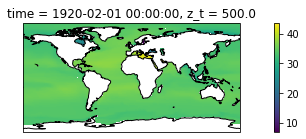

In [8]:
plt.figure(figsize=(12, 2))
ax = plt.axes(projection=ccrs.PlateCarree())
regrid_cesm[0,:,:].plot.pcolormesh(ax=ax, x="lon", y="lat")
ax.coastlines()

#Ok we've regridded to rectilinear grid

OK this verifies that we can regrid to a rectilinear grid. Now, we want to take the mean over many ensemble members, regrid them all, and then take the mean.

In [10]:
#take mean of the salt members
salt=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.00%d.pop.h.SALT.192001-200512.nc" % i
    else:
        f="/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.0%d.pop.h.SALT.192001-200512.nc" % i
    s=xr.open_dataset(f)['SALT']
    salt.append(s[:,0,:,:])
    print(i)
    #xr.close_dataset(f)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [11]:
#now we have a list of the salts from the 34 realizations 
#We must regrid them all 
regridded_salt=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(salt[i])
    regridded_salt.append(s)
    print(i)

0


KeyboardInterrupt: 

In [24]:
#take mean of the salt members
salt_2005on=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.00%d.pop.h.SALT.200601-208012.nc" % i
    elif i<34:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.SALT.200601-208012.nc" % i
    else:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.SALT.200601-210012.nc" % i
    s=xr.open_dataset(f)['SALT']
    salt_2005on.append(s[:,0,:,:])
    print(i)
    #xr.close_dataset(f)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [25]:
#now we have a list of the salts from the 20 realizations 
#We must regrid them all 
regridded_salt_2005on=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(salt_2005on[i])
    regridded_salt_2005on.append(s)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


Let's import and regrid the SST fields

In [28]:
#we may need to smooth over natural variaibility to get a less noisy convolution
# Let's try the mean of 5 ensemble members 
#run this or the previous cell depending if you want ssp885 or 1pct co2
temp=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.B20TRC5CNBDRD.f09_g16.00%d.pop.h.TEMP.192001-200512.nc" % i
    else:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.B20TRC5CNBDRD.f09_g16.0%d.pop.h.TEMP.192001-200512.nc" % i
    s=xr.open_dataset(f)['TEMP']
    temp.append(s[:,0,:,:])
    print(i)
    #xr.close_dataset(f)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [30]:
#take mean of the salt members
temp_2005on=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.00%d.pop.h.TEMP.200601-208012.nc" % i
    elif i<34:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.TEMP.200601-208012.nc" % i
    else:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.TEMP.200601-210012.nc" % i
    s=xr.open_dataset(f)['TEMP']
    temp_2005on.append(s[:,0,:,:])
    print(i)
    #xr.close_dataset(f)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [31]:
#now we have a list of the salts from the 20 realizations 
#We must regrid them all 
regridded_temp=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(temp[i])
    regridded_temp.append(s)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [33]:
#now we have a list of the salts from the 20 realizations 
#We must regrid them all 
regridded_temp_2005on=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(temp_2005on[i])
    regridded_temp_2005on.append(s)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


IndexError: list index out of range

In [26]:
import pickle
with open("regridded_salt_1920to2005_historical", "wb") as fp:   #Pickling
    pickle.dump(regridded_salt, fp)

In [27]:
import pickle
with open("regridded_salt_2006to2080_rcp8.5", "wb") as fp:   #Pickling
    pickle.dump(regridded_salt_2005on, fp)

In [32]:
import pickle
with open("regridded_temp", "wb") as fp:   #Pickling
    pickle.dump(regridded_temp, fp)

In [38]:
import pickle
with open("regridded_temp_2006to2080_rcp8.5", "wb") as fp:   #Pickling
    pickle.dump(regridded_temp_2005on, fp)

In [9]:
import pickle
with open("regridded_salt_1920to2005_historical", "rb") as fp:   # Unpickling
    regridded_salt= pickle.load(fp)

with open("regridded_salt_2006to2080_rcp8.5", "rb") as fp:   # Unpickling
    regridded_salt_2005on= pickle.load(fp)
    
with open("regridded_temp", "rb") as fp:   # Unpickling
    regridded_temp= pickle.load(fp)
    
with open("regridded_temp_2006to2080_rcp8.5", "rb") as fp:   # Unpickling
    regridded_temp_2005on= pickle.load(fp)

Regridded salt gives the salt from the period 1920 to 2005. 

In [10]:
salt_avg_pre2005=sum(regridded_salt)/34
salt_avg_pre2005=salt_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
salt_avg_pre2005=salt_avg_pre2005.assign_coords(latitude=salt_avg_pre2005.lat[:,0],longitude=salt_avg_pre2005.lon[0,:])

salt_avg_2005on=sum(regridded_salt_2005on)/34
salt_avg_2005on=salt_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_avg_2005on=salt_avg_2005on.assign_coords(latitude=salt_avg_2005on.lat[:,0],longitude=salt_avg_2005on.lon[0,:])

In [11]:
#individual members of the salt
salt_pre2005_list=[]
for i in range(0,34):
    s=regridded_salt[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    salt_pre2005_list.append(s)

salt_2005on_list=[]
for i in range(0,34):
    s=regridded_salt_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    salt_2005on_list.append(s)
    
salt_list=[]
for i in range(0,34):
    s=xr.concat([salt_pre2005_list[i],salt_2005on_list[i]],dim="time")
    salt_list.append(s[12*55:12*105,:,:]) #cut to 1975 to 2025
    #salt_list.append(s[12*50:12*100,:,:]) #cut to 1970 to 2020

In [12]:
#individual members of the temp
temp_pre2005_list=[]
for i in range(0,34):
    s=regridded_temp[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    temp_pre2005_list.append(s)

temp_2005on_list=[]
for i in range(0,34):
    s=regridded_temp_2005on[i].rename({'y': 'latitude','x': 'longitude'})
    s=s.assign_coords(latitude=s.lat[:,0],longitude=s.lon[0,:])
    temp_2005on_list.append(s)
    
temp_list=[]
for i in range(0,34):
    s=xr.concat([temp_pre2005_list[i],temp_2005on_list[i]],dim="time")
    temp_list.append(s[12*55:12*105,:,:]) #cut to 1975 to 2025
    #temp_list.append(s[12*50:12*100,:,:]) #cut to 1970 to 2020

In [13]:
salt_avg=xr.concat([salt_avg_pre2005,salt_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
#salt_avg_1970to2020=salt_avg[12*50:12*100,:,:]
salt_avg_1970to2020=salt_avg[12*55:12*105,:,:]

In [14]:
temp_avg_pre2005=sum(regridded_temp)/34
temp_avg_pre2005=temp_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
temp_avg_pre2005=temp_avg_pre2005.assign_coords(latitude=temp_avg_pre2005.lat[:,0],longitude=temp_avg_pre2005.lon[0,:])

temp_avg_2005on=sum(regridded_temp_2005on)/34
temp_avg_2005on=temp_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
temp_avg_2005on=temp_avg_2005on.assign_coords(latitude=temp_avg_2005on.lat[:,0],longitude=temp_avg_2005on.lon[0,:])

In [15]:
temp_avg=xr.concat([temp_avg_pre2005,temp_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
#temp_avg_1970to2020=temp_avg[12*50:12*100,:,:]
temp_avg_1970to2020=temp_avg[12*55:12*105,:,:] #this is 1975 to 2025

In [16]:
from area_grid import *

area=area_grid(latitudes=np.array(salt_avg[0,:,:].latitude),longitudes=salt_avg[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_avg[0,:,:].latitude,salt_avg[0,:,:].longitude])

1.0


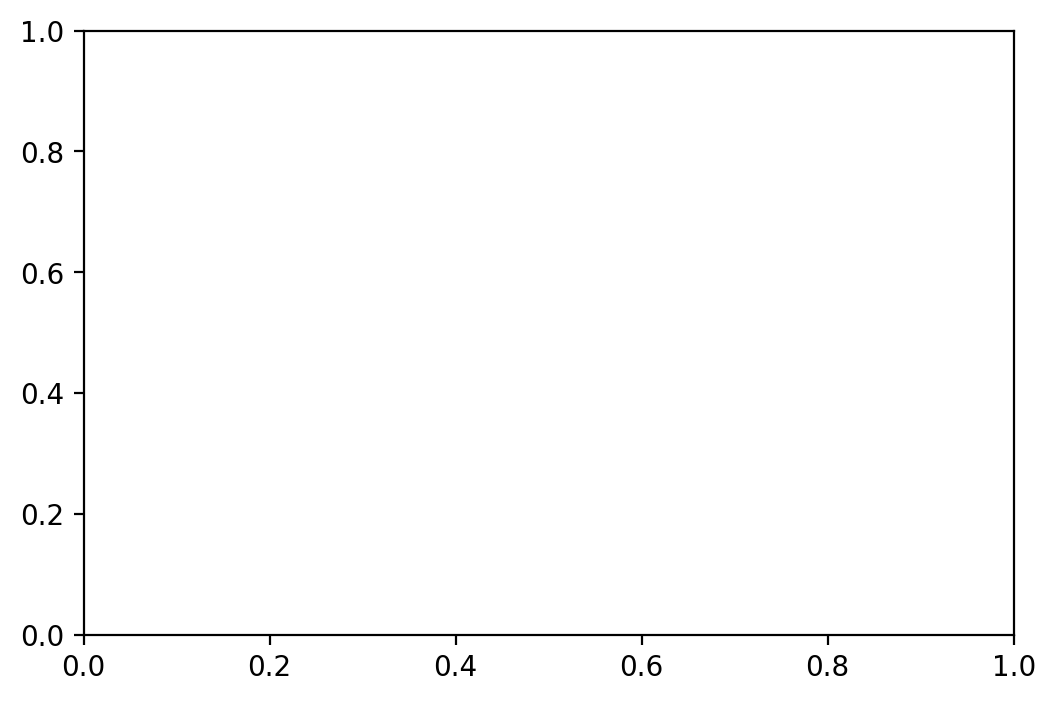

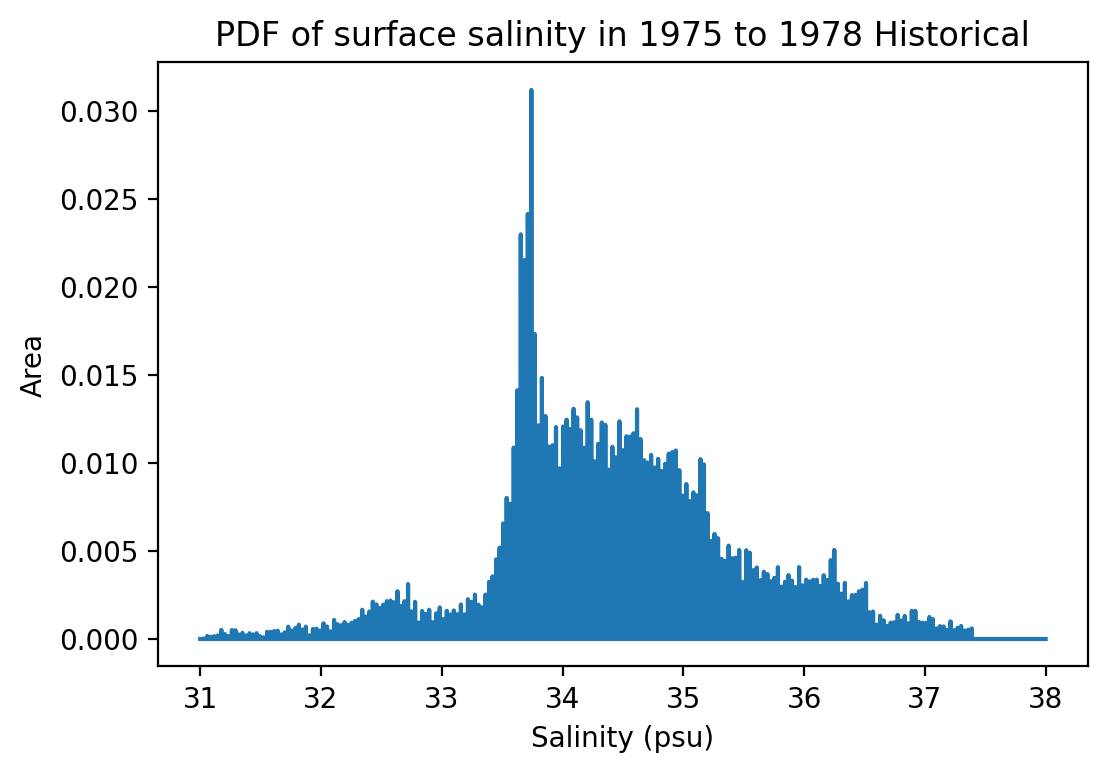

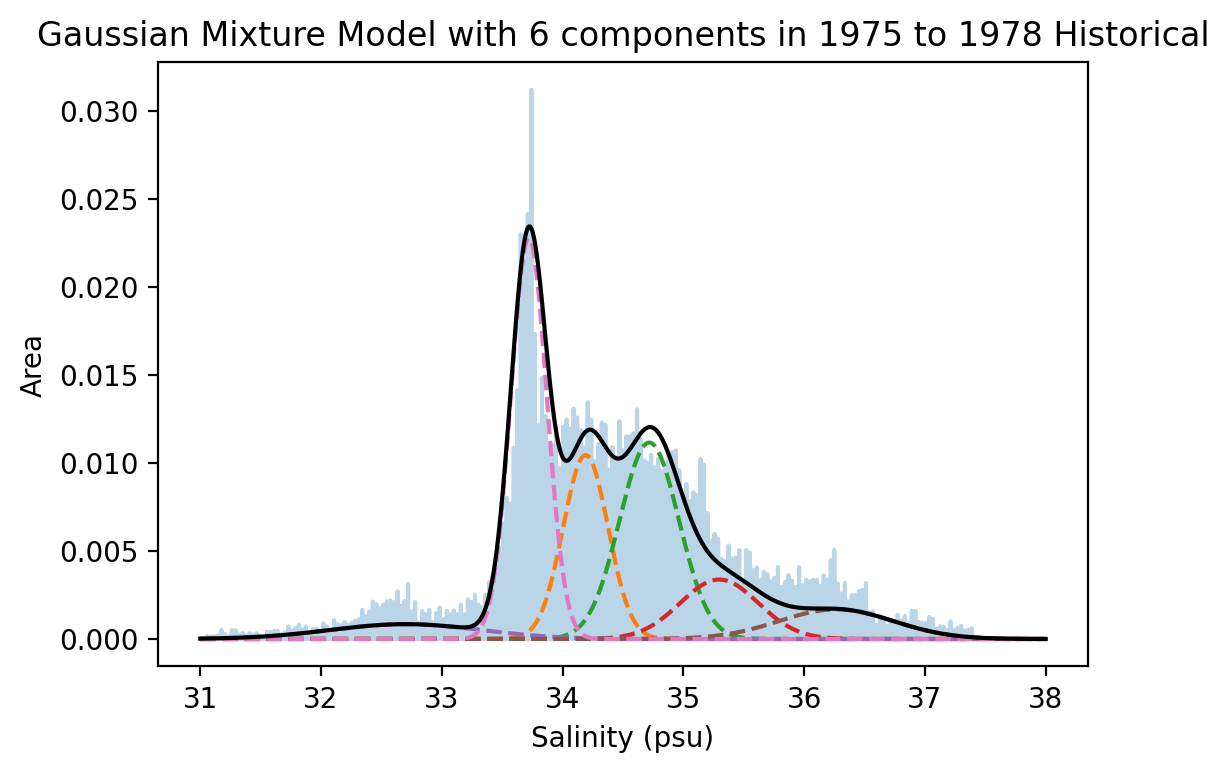

In [17]:
n=6 #or n=7
%load_ext autoreload
%autoreload 2
from percentiles_function import GMM_timedep
from percentiles_function import AIC_BIC_timedep
mean_had_con,sigma_had_con,weights_had_con,gm=GMM_timedep((salt_avg_1970to2020[0*12:3*12,:,:].mean('time')).where(salt_avg[0,:,:].latitude<65),n,'1975 to 1978 Historical') #take mean over first year

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


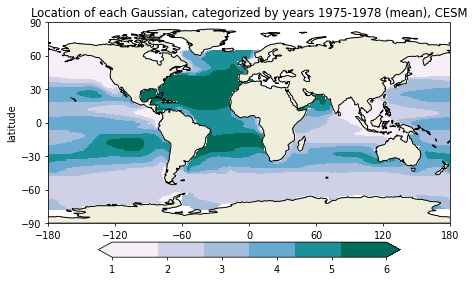

In [18]:
from linear_response_functions import clusters
%load_ext autoreload
%autoreload 2
y,a2=clusters(gm,salt_avg_1970to2020[0*12:3*12,:,:].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), CESM',n)

In [19]:
#Let's now find the mean salinity in each of these regions in each year. 
#First, we define the way of area weighting
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

In [20]:
#s=(salt_avg_1970to2020[0:5*12,:,:].mean('time')).where(salt_avg.latitude<65)
s=(salt_avg_1970to2020[0*12:3*12,:,:].mean('time')).where(salt_avg.latitude<65)

x=np.linspace(31,38,10000)
#we have a 50 year time series, we want to find the mean salt at each region defined by the first year at each of these years
salt_cesm=np.empty([50,n])
temp_cesm=np.empty([50,n])
for j in range(0,50):
    s_new=(salt_avg_1970to2020[j*12:(j+1)*12,:,:].mean('time')).where(salt_avg.latitude<65)
    t_new=(temp_avg_1970to2020[j*12:(j+1)*12,:,:].mean('time')).where(temp_avg.latitude<65)
    for i in range(0,n):
        salt_cesm[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)

In [21]:
(((temp_avg_1970to2020[48*12:49*12,:,:].mean('time')*area).where(salt_avg.latitude<65)).sum()/((area).where(salt_avg.latitude<65)).sum())-(((temp_avg_1970to2020[0:12,:,:].mean('time')*area).where(salt_avg.latitude<65)).sum()/((area).where(salt_avg.latitude<65)).sum())

<xarray.DataArray ()>
array(0.50698946)
Coordinates:
    z_t      float32 500.0

In [22]:
plt.rcParams['figure.dpi'] = 200

Text(0.5, 1.0, 'Change in salinity in each region CESM')

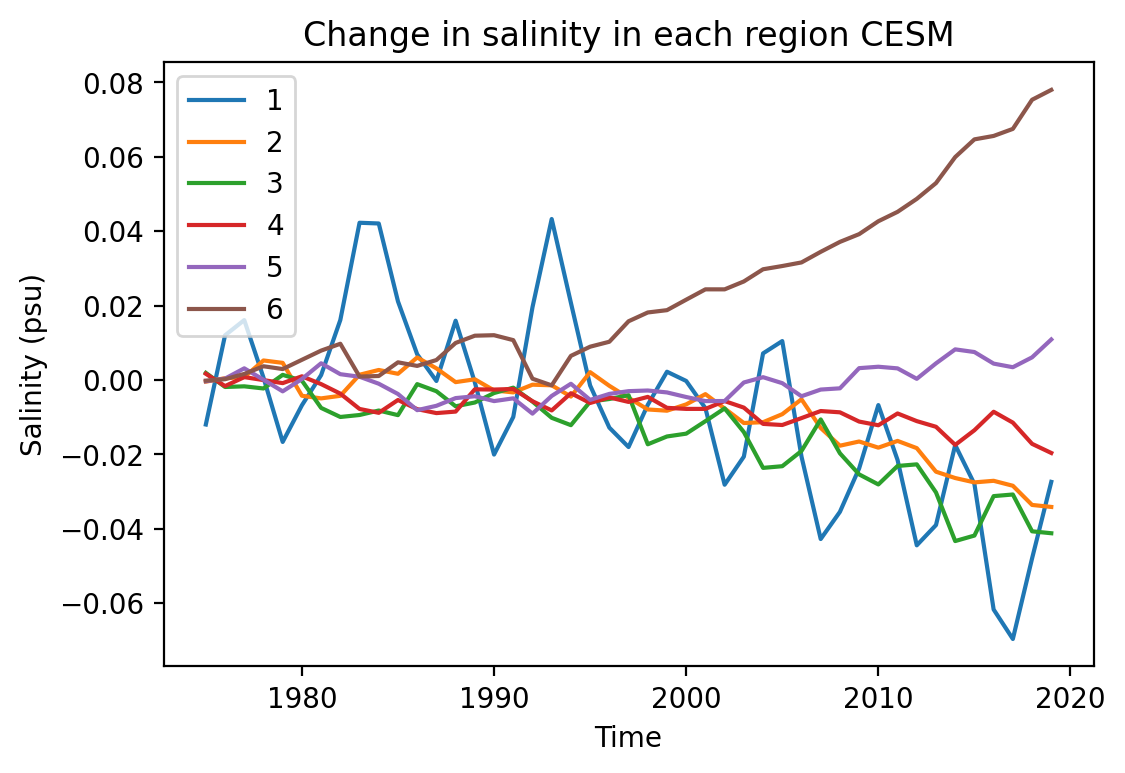

In [23]:
change_cesm=salt_cesm[:,:]-np.mean(salt_cesm[0:2,:],0)
plt.plot(np.linspace(1975,2019,45),change_cesm[0:45])
#plt.legend(['1','2','3','4','5','6'])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region CESM')


In [55]:
%store change_cesm
%store a2
%store salt_avg_1970to2020

Stored 'change_cesm' (ndarray)
Stored 'a2' (ndarray)
Stored 'salt_avg_1970to2020' (DataArray)


In [24]:
#GET CHANGE IN JUST ONE MEMBER. IMPORT THIS TO TRY BOOTSTRAPPING IN BOOTSTRAP.IPYNB
s=(salt_avg_1970to2020[0*12:3*12,:,:].mean('time')).where(salt_avg.latitude<65)

x=np.linspace(31,38,10000)
#we have a 50 year time series, we want to find the mean salt at each region defined by the first year at each of these years
salt_cesm_member1=np.empty([50,n])
temp_cesm_member1=np.empty([50,n])
for j in range(0,50):
    s_new=(salt_list[0][j*12:(j+1)*12,:,:].mean('time')).where(salt_avg.latitude<65)
    t_new=(temp_list[0][j*12:(j+1)*12,:,:].mean('time')).where(temp_avg.latitude<65)
    for i in range(0,n):
        salt_cesm_member1[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm_member1[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
change_cesm_member1=salt_cesm_member1[:,:]-np.mean(salt_cesm_member1[0:2,:],0)
change_cesm_temp_member1=temp_cesm_member1[:,:]-np.mean(temp_cesm_member1[0:2,:],0)

In [25]:
change_cesm_member1=salt_cesm_member1[:,:]-np.mean(salt_cesm_member1[0:2,:],0)
change_cesm_temp_member1=temp_cesm_member1[:,:]-np.mean(temp_cesm_member1[0:2,:],0)
%store change_cesm_member1
%store change_cesm_temp_member1


salt_cesm_member2=np.empty([50,n])
temp_cesm_member2=np.empty([50,n])
for j in range(0,50):
    s_new=(salt_list[1][j*12:(j+1)*12,:,:].mean('time')).where(salt_avg.latitude<65)
    t_new=(temp_list[1][j*12:(j+1)*12,:,:].mean('time')).where(temp_avg.latitude<65)
    for i in range(0,n):
        salt_cesm_member2[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm_member2[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
        
        
change_cesm_member2=salt_cesm_member2[:,:]-np.mean(salt_cesm_member2[0:2,:],0)
change_cesm_temp_member2=temp_cesm_member2[:,:]-np.mean(temp_cesm_member2[0:2,:],0)
%store change_cesm_member2
%store change_cesm_temp_member2

Stored 'change_cesm_member1' (ndarray)
Stored 'change_cesm_temp_member1' (ndarray)
Stored 'change_cesm_member2' (ndarray)
Stored 'change_cesm_temp_member2' (ndarray)


In [30]:
%store salt_list
%store temp_list
%store salt_avg
%store temp_avg
%store s
%store x
%store a2
%store area

Stored 'salt_list' (list)
Stored 'temp_list' (list)
Stored 'salt_avg' (DataArray)
Stored 'temp_avg' (DataArray)
Stored 's' (DataArray)
Stored 'x' (ndarray)
Stored 'a2' (ndarray)
Stored 'area' (DataArray)


Text(0.5, 1.0, 'Change in temperature in each region CESM')

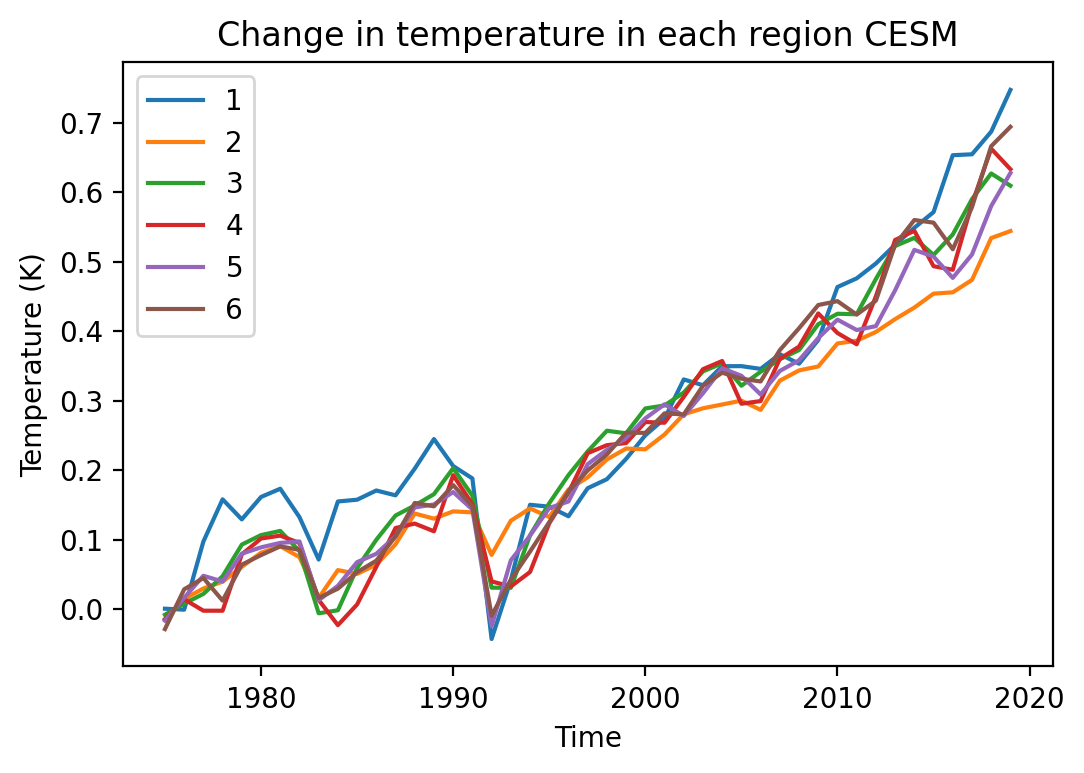

In [26]:
change_temp_cesm=temp_cesm[:,:]-np.mean(temp_cesm[0:2,:],0)
plt.plot(np.linspace(1975,2019,45),change_temp_cesm[0:45])
#plt.legend(['1','2','3','4','5','6'])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region CESM')

In [1]:
%store change_temp_cesm

UsageError: Unknown variable 'change_temp_cesm'


In [27]:
from linear_response_functions import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2
temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(salt_avg_1970to2020,area,a2,n)

from linear_response_functions import regridded_fafmip
%load_ext autoreload
%autoreload 2
salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(salt_avg_1970to2020,area,a2,n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

Text(0.5, 1.0, 'Change in salinity in each region due to freshwater flux forcing, ACCESS-OM2')

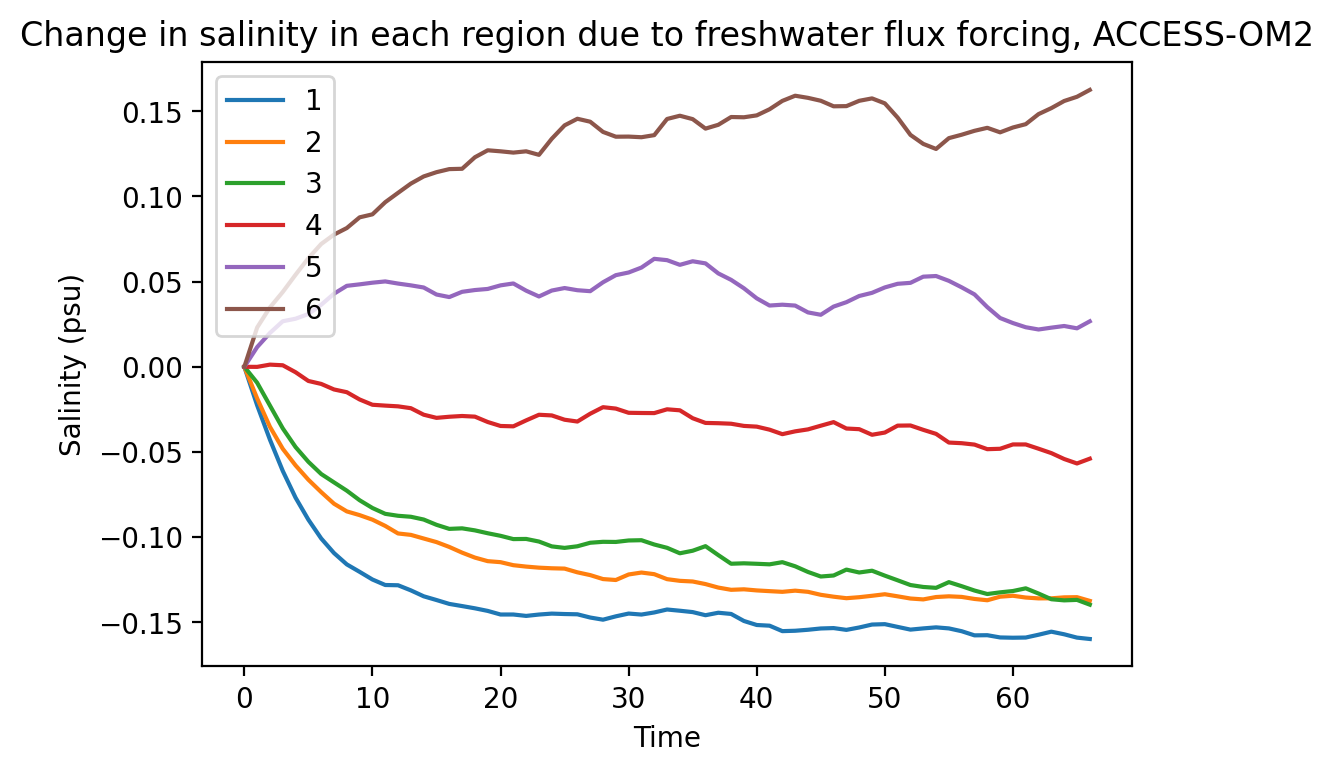

In [28]:
plt.plot(salt_access_water[0:67,:]-salt_access_water[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region due to freshwater flux forcing, ACCESS-OM2')

Text(0.5, 1.0, 'Change in temperature in each region due to heat flux forcing, ACCESS-OM2')

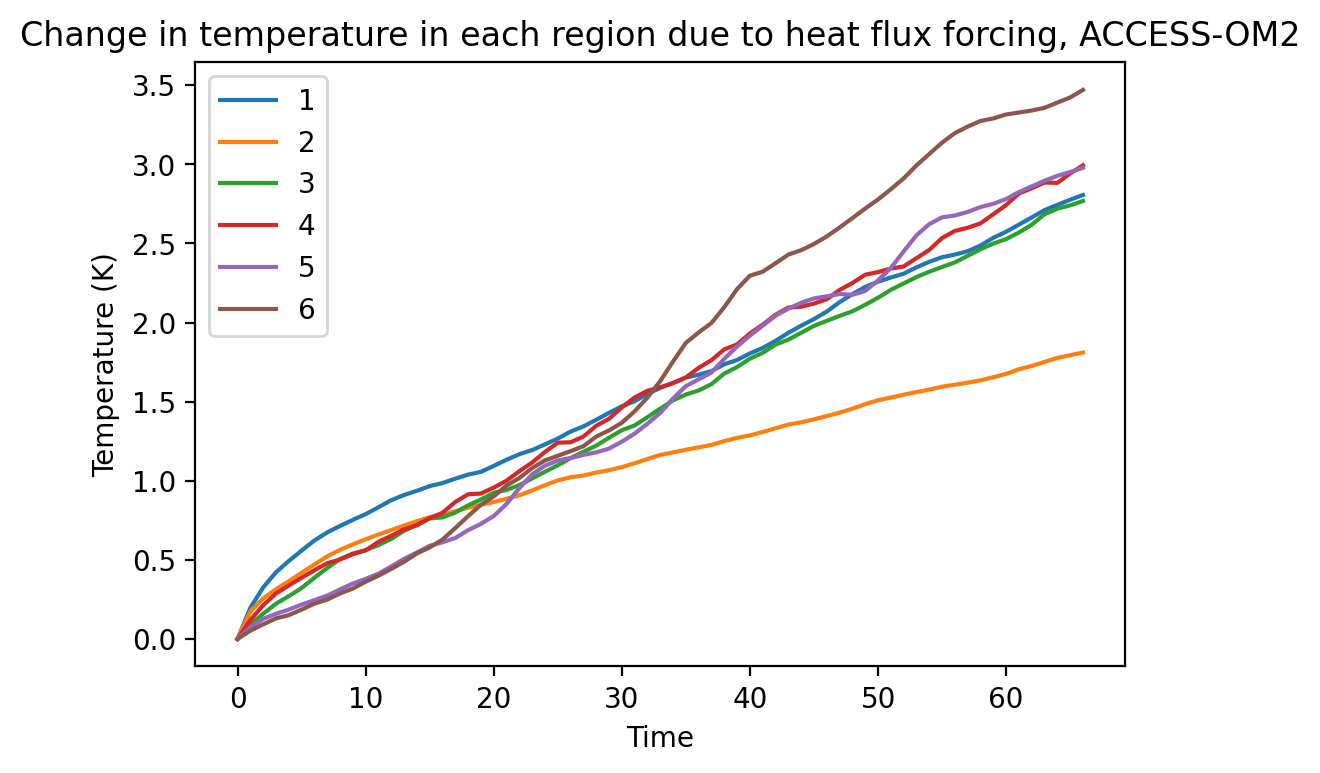

In [29]:
plt.plot(temp_access_heat[0:67,:]-temp_access_heat[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region due to heat flux forcing, ACCESS-OM2')

Text(0.5, 1.0, 'Change in salinity in each region due to heat flux forcing, ACCESS-OM2')

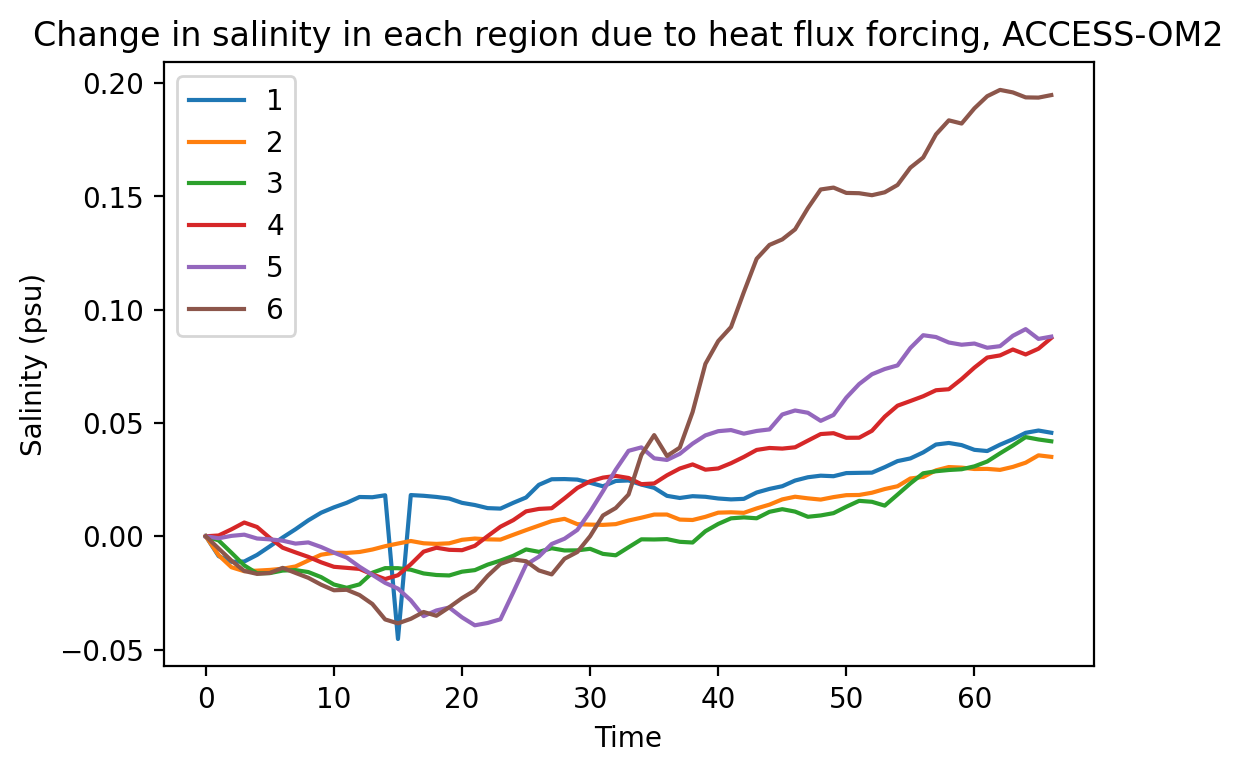

In [34]:
plt.plot(salt_access_heat[0:67,:]-salt_access_heat[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region due to heat flux forcing, ACCESS-OM2')

Text(0.5, 1.0, 'Change in temperature in each region due to wind stress forcing, ACCESS-OM2')

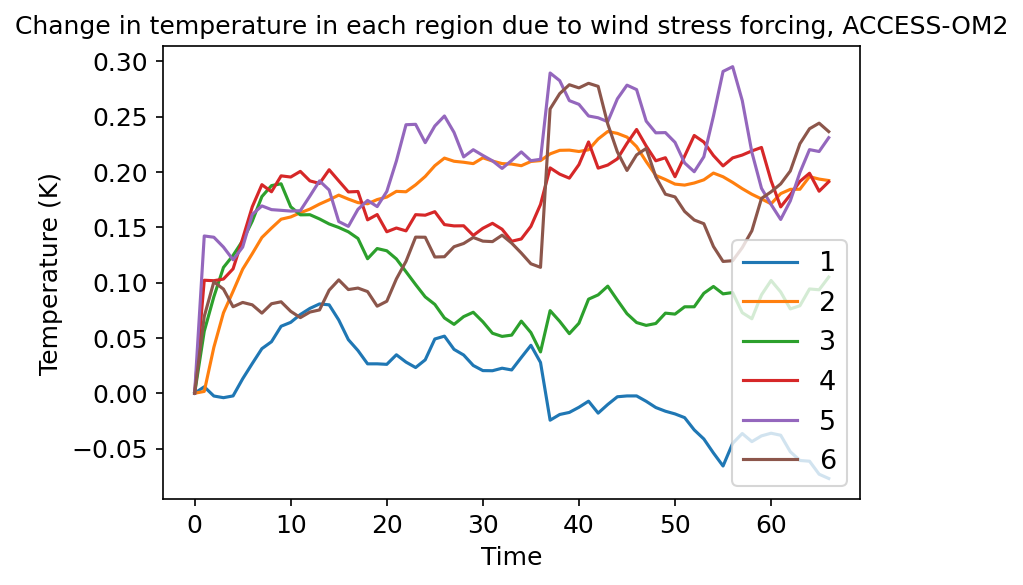

In [156]:
plt.plot(temp_access_stress[0:67,:]-temp_access_stress[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region due to wind stress forcing, ACCESS-OM2')

Text(0.5, 1.0, 'Change in temperature in each region due to freshwater flux forcing, ACCESS-OM2')

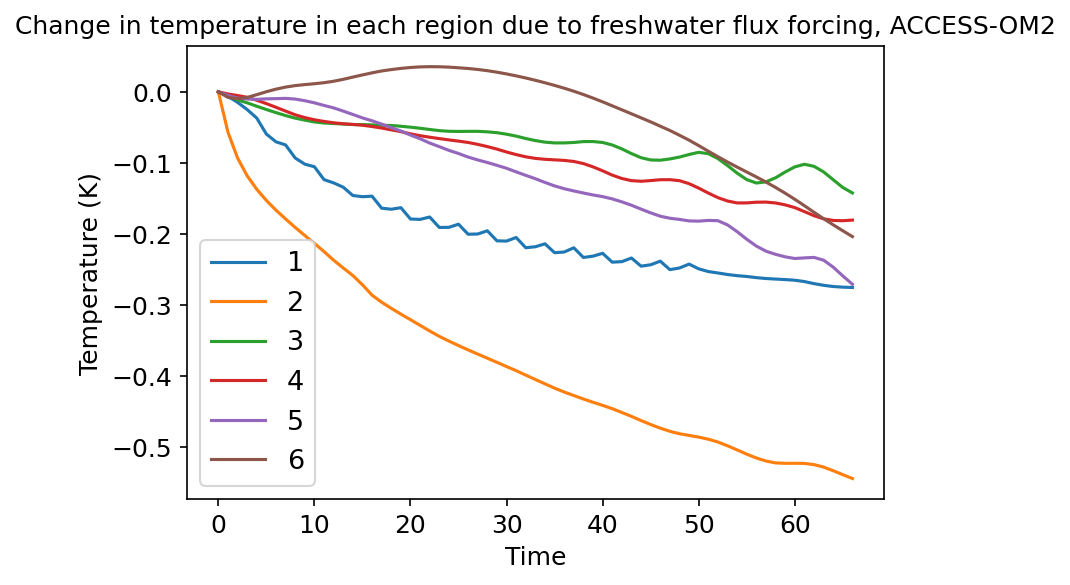

In [137]:
plt.plot(temp_mit_water[0:67,:]-temp_mit_water[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region due to freshwater flux forcing, ACCESS-OM2')

Text(0.5, 1.0, 'Change in salinity in each region due to wind stress forcing, ACCESS-OM2')

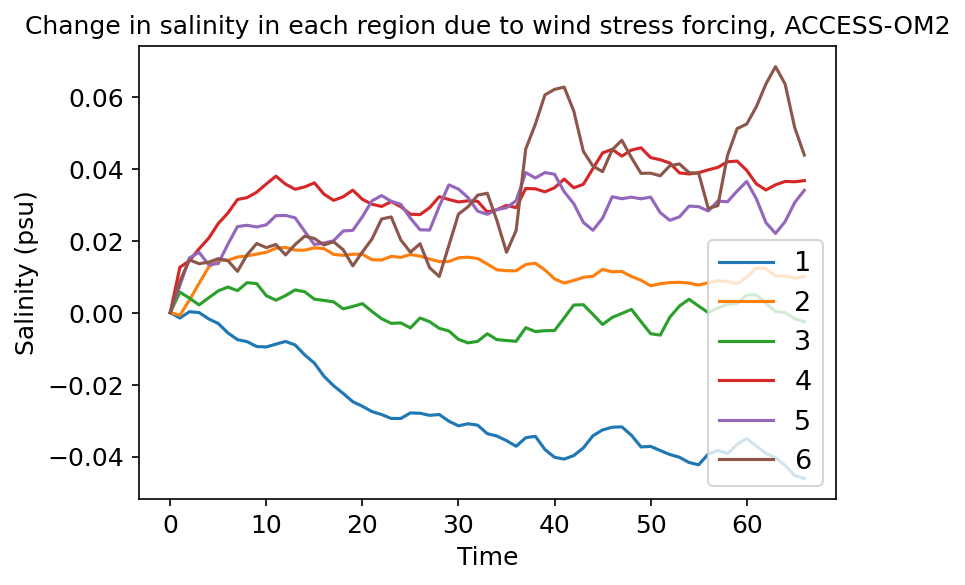

In [157]:
plt.plot(salt_access_stress[0:67,:]-salt_access_stress[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region due to wind stress forcing, ACCESS-OM2')

In [35]:
change_water=salt_had_water[:,:]-salt_had_water[0,:]
change_heat=salt_had_heat[:,:]-salt_had_heat[0,:]
change_stress=salt_had_stress[:,:]-salt_had_stress[0,:]
change_water_temp=temp_had_water[:,:]-temp_had_water[0,:]
change_heat_temp=temp_had_heat[:,:]-temp_had_heat[0,:]
change_stress_temp=temp_had_stress[:,:]-temp_had_stress[0,:]


da = xr.DataArray(change_water)
change_water=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat)
change_heat=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress)
change_stress=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_water_temp)
change_water_temp=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat_temp)
change_heat_temp=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress_temp)
change_stress_temp=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')

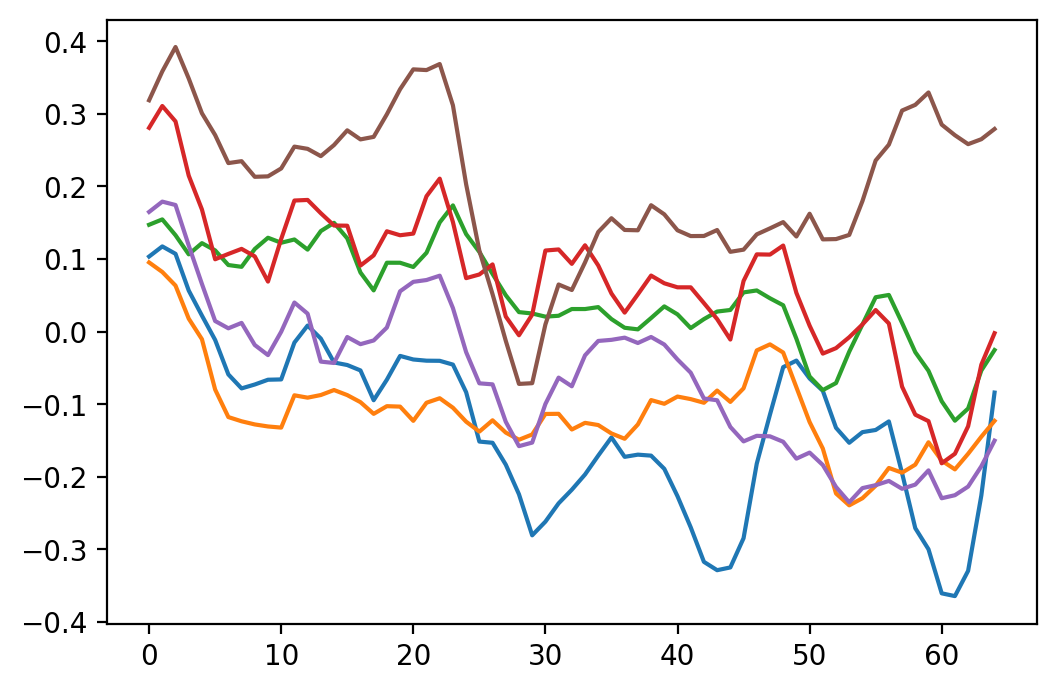

In [36]:
plt.plot(change_water_temp)

Text(0.5, 1.0, 'Change in temperature in each region due to wind stress forcing, ACCESS-OM2')

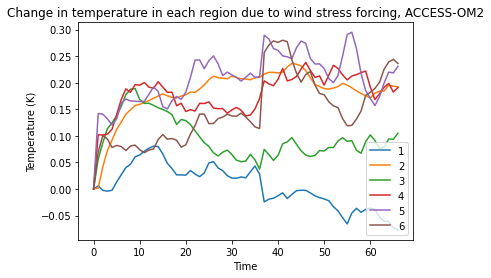

In [63]:
plt.plot(temp_access_stress[0:67,:]-temp_access_stress[0,:])
plt.legend(['1','2','3','4','5','6'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region due to wind stress forcing, ACCESS-OM2')

In [30]:
start_yr=15
end_yr=19

#df=np.zeros([50,end_yr-start_yr,3,2])
#df2=np.zeros([50,end_yr-start_yr,3,2])
#df4=np.zeros([50,end_yr-start_yr,3,2])
#dist=np.zeros([50,end_yr-start_yr,3])
df=np.zeros([50,end_yr-start_yr,3,3])
df2=np.zeros([50,end_yr-start_yr,3,3])
df4=np.zeros([50,end_yr-start_yr,3,3])
dist=np.zeros([50,end_yr-start_yr,3])
for p in range(0,3):

    access1mit0had2=p

    start_yr=15
    end_yr=19
    for start in range(start_yr,end_yr):

        if access1mit0had2==0:
            change_water=salt_mit_water[:,:]-salt_mit_water[0,:]
            change_heat=salt_mit_heat[:,:]-salt_mit_heat[0,:]
            change_stress=salt_mit_stress[:,:]-salt_mit_stress[0,:]
            change_water_temp=temp_mit_water[:,:]-temp_mit_water[0,:]
            change_heat_temp=temp_mit_heat[:,:]-temp_mit_heat[0,:]
            change_stress_temp=temp_mit_stress[:,:]-temp_mit_stress[0,:]
        elif access1mit0had2==1:
            change_water=salt_access_water[:,:]-salt_access_water[0,:]
            change_heat=salt_access_heat[:,:]-salt_access_heat[0,:]
            change_stress=salt_access_stress[:,:]-salt_access_stress[0,:]
            change_water_temp=temp_access_water[:,:]-temp_access_water[0,:]
            change_heat_temp=temp_access_heat[:,:]-temp_access_heat[0,:]
            change_stress_temp=temp_access_stress[:,:]-temp_access_stress[0,:]
        elif access1mit0had2==2:
            change_water=salt_had_water[:,:]-salt_had_water[0,:]
            change_heat=salt_had_heat[:,:]-salt_had_heat[0,:]
            change_stress=salt_had_stress[:,:]-salt_had_stress[0,:]
            change_water_temp=temp_had_water[:,:]-temp_had_water[0,:]
            change_heat_temp=temp_had_heat[:,:]-temp_had_heat[0,:]
            change_stress_temp=temp_had_stress[:,:]-temp_had_stress[0,:]
            
        if p==2:
           da = xr.DataArray(change_water)
           change_water=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_heat)
           change_heat=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_stress)
           change_stress=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_water_temp)
           change_water_temp=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_heat_temp)
           change_heat_temp=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_stress_temp)
           change_stress_temp=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')

        #a=np.max(change_temp_cesm2)/np.max(change_cesm2)
        a=np.linalg.norm(change_temp_cesm)/np.linalg.norm(change_cesm)

        change2_water=np.concatenate((change_water[start:71],change_water_temp[start:71]/a),axis=1)
        change2_heat=np.concatenate((change_heat[start:71],change_heat_temp[start:71]/a),axis=1)
        if p==1:
            change2_stress=np.concatenate((change_stress[start:67],change_stress_temp[start:71]/a),axis=1)
        elif p==2:
            change2_stress=np.concatenate((change_stress[start:71],change_stress_temp[start:71]/a),axis=1)
        elif p==0:
            change2_stress=np.concatenate((change_stress[start:71],change_stress_temp[start:71]/a),axis=1)

        change_cesm2_stack=np.concatenate((change_cesm,change_temp_cesm/a),axis=1)
        
        for i in range(0,49):
            sum=np.zeros(2*n)
            for j in range(0,i):
                B=np.concatenate((np.matrix(change2_water[i-j,:]).T,np.matrix(change2_heat[i-j,:]).T,np.matrix(change2_stress[i-j,:]).T),axis=1)
                sum=((B)*np.matrix(df[j,start-start_yr,:,p]).T).T+sum
            RHS=change_cesm2_stack[i+1,:].T-sum
            A=np.concatenate((np.matrix(change2_water[0,:]).T,np.matrix(change2_heat[0,:]).T,np.matrix(change2_stress[0,:]).T),axis=1)
            #A=np.concatenate((np.matrix(change2_water[0,:]).T,np.matrix(change2_heat[0,:]).T),axis=1)
            #df[i,start-start_yr,:,p]=(np.linalg.inv(np.matmul(A.T,A))*np.matmul(A.T,np.matrix(RHS).T)).reshape(3)
            #dist[i,start-start_yr,p] = np.linalg.norm(np.matmul(A,df[i,start-start_yr,:,p])-RHS)
            x, residuals, rank, s=np.linalg.lstsq(A,np.matrix(RHS).T,rcond = -1)
            df[i,start-start_yr,:,p]=x.reshape(3)


        for k in range(0,3):
            df2[:,start-start_yr,k,p]=(df[:,start-start_yr,k,p].cumsum())-(df[:,start-start_yr,k,p].cumsum())[0] #subtract off so starts from 0
            df4[:,start-start_yr,k,p]=(df[:,start-start_yr,k,p].cumsum()) #don't subtract off so starts at 0
        df3=np.mean(df2,axis=1) #mean over the start years where we subtracted off
        df5=np.mean(df4,axis=1) #mean over the start years where we didn't make start from 0
df3_mean=np.mean(df3,axis=2)
df5_mean=np.mean(df5,axis=2)

0.4044435208484074
0.37395713344976106
0.4349299082470538


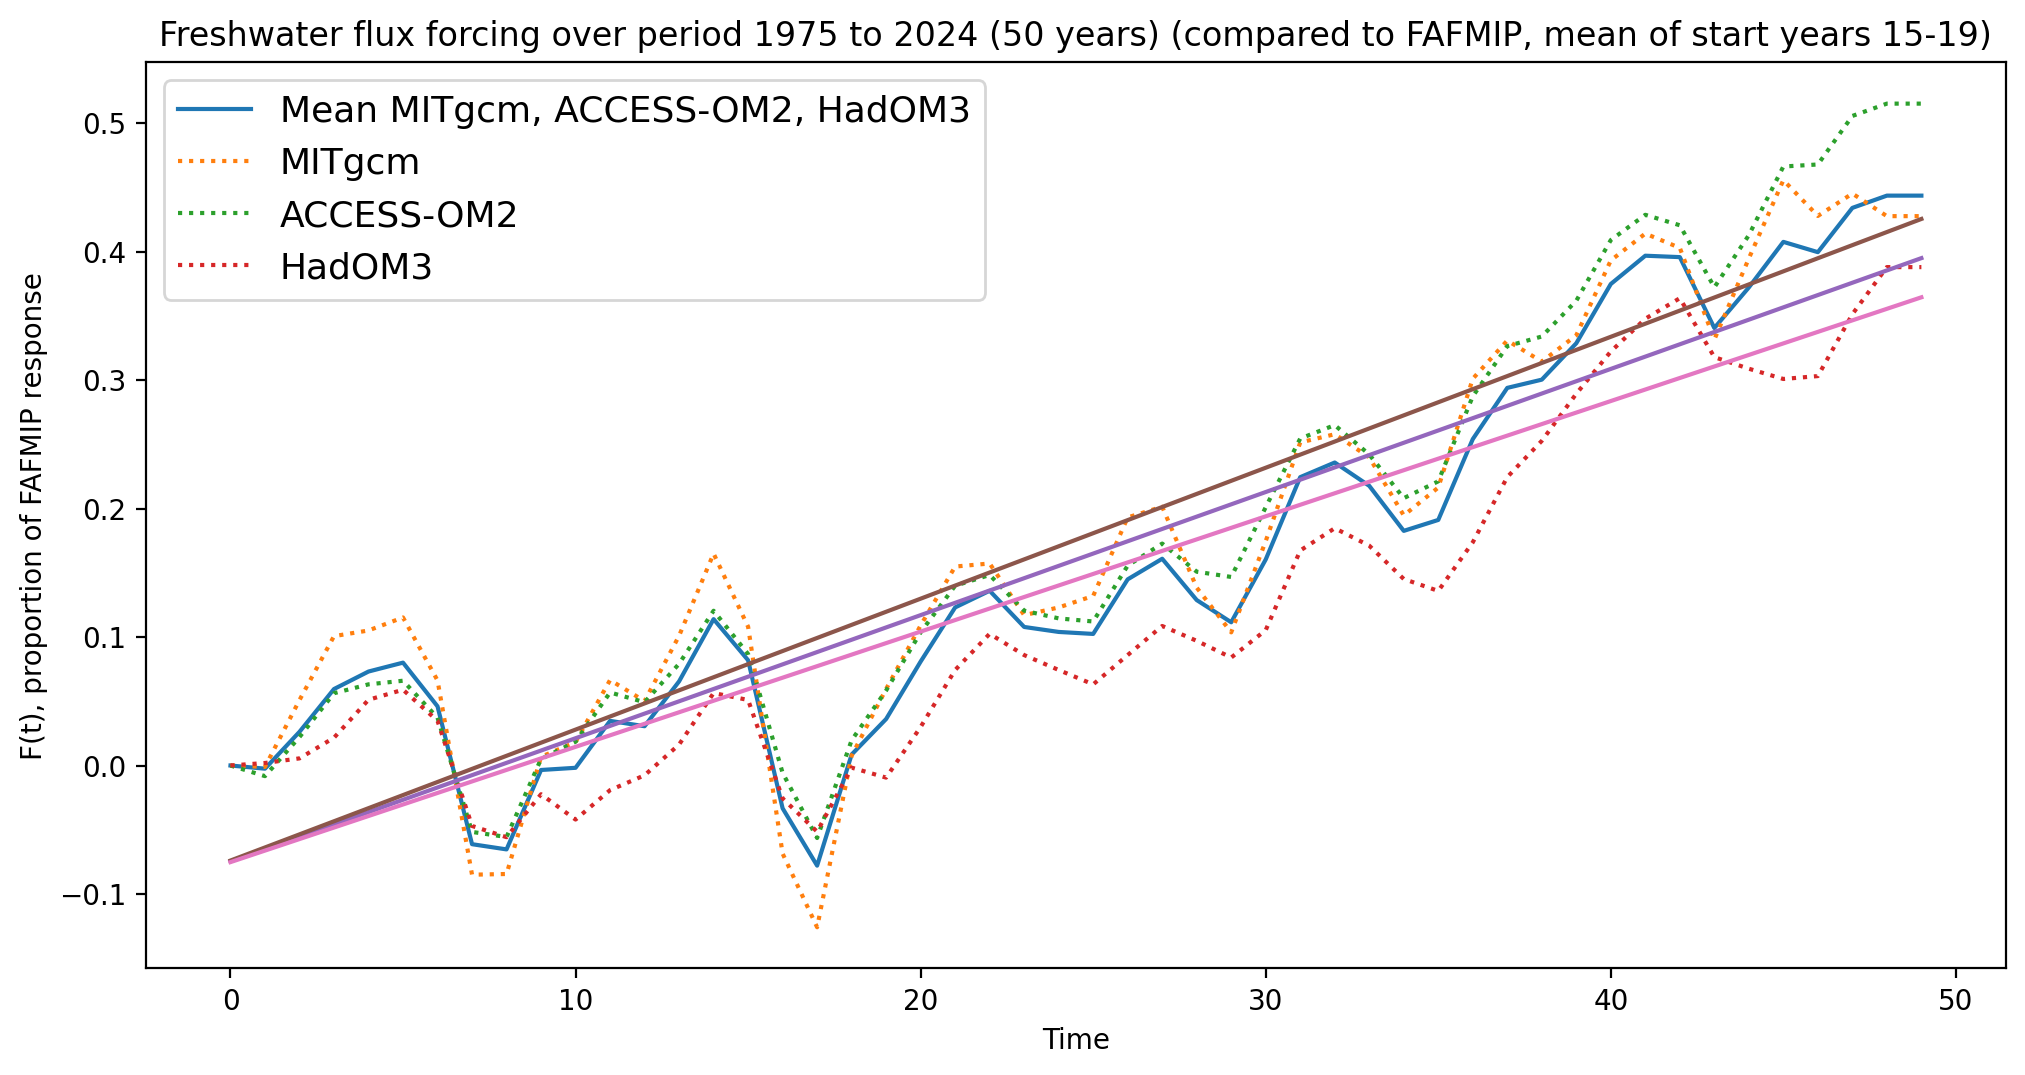

In [82]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(df3_mean[:,0])
plt.plot(df3[:,0,0],':')
plt.plot(df3[:,0,1],':')
plt.plot(df3[:,0,2],':')
plt.title('Freshwater flux forcing over period 1975 to 2024 (50 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,49,50), y=df3_mean[:,0], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
plt.plot(np.linspace(0,49,50), p.intercept + p.slope*np.linspace(0,49,50))
plt.plot(np.linspace(0,49,50), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,49,50))
plt.plot(np.linspace(0,49,50), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,49,50))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(p.slope*50+p.intercept)
print((p.slope-p.stderr)*50+p.intercept)
print((p.slope+p.stderr)*50+p.intercept)

0.3320390402974017
0.29990647493015044
0.364171605664653


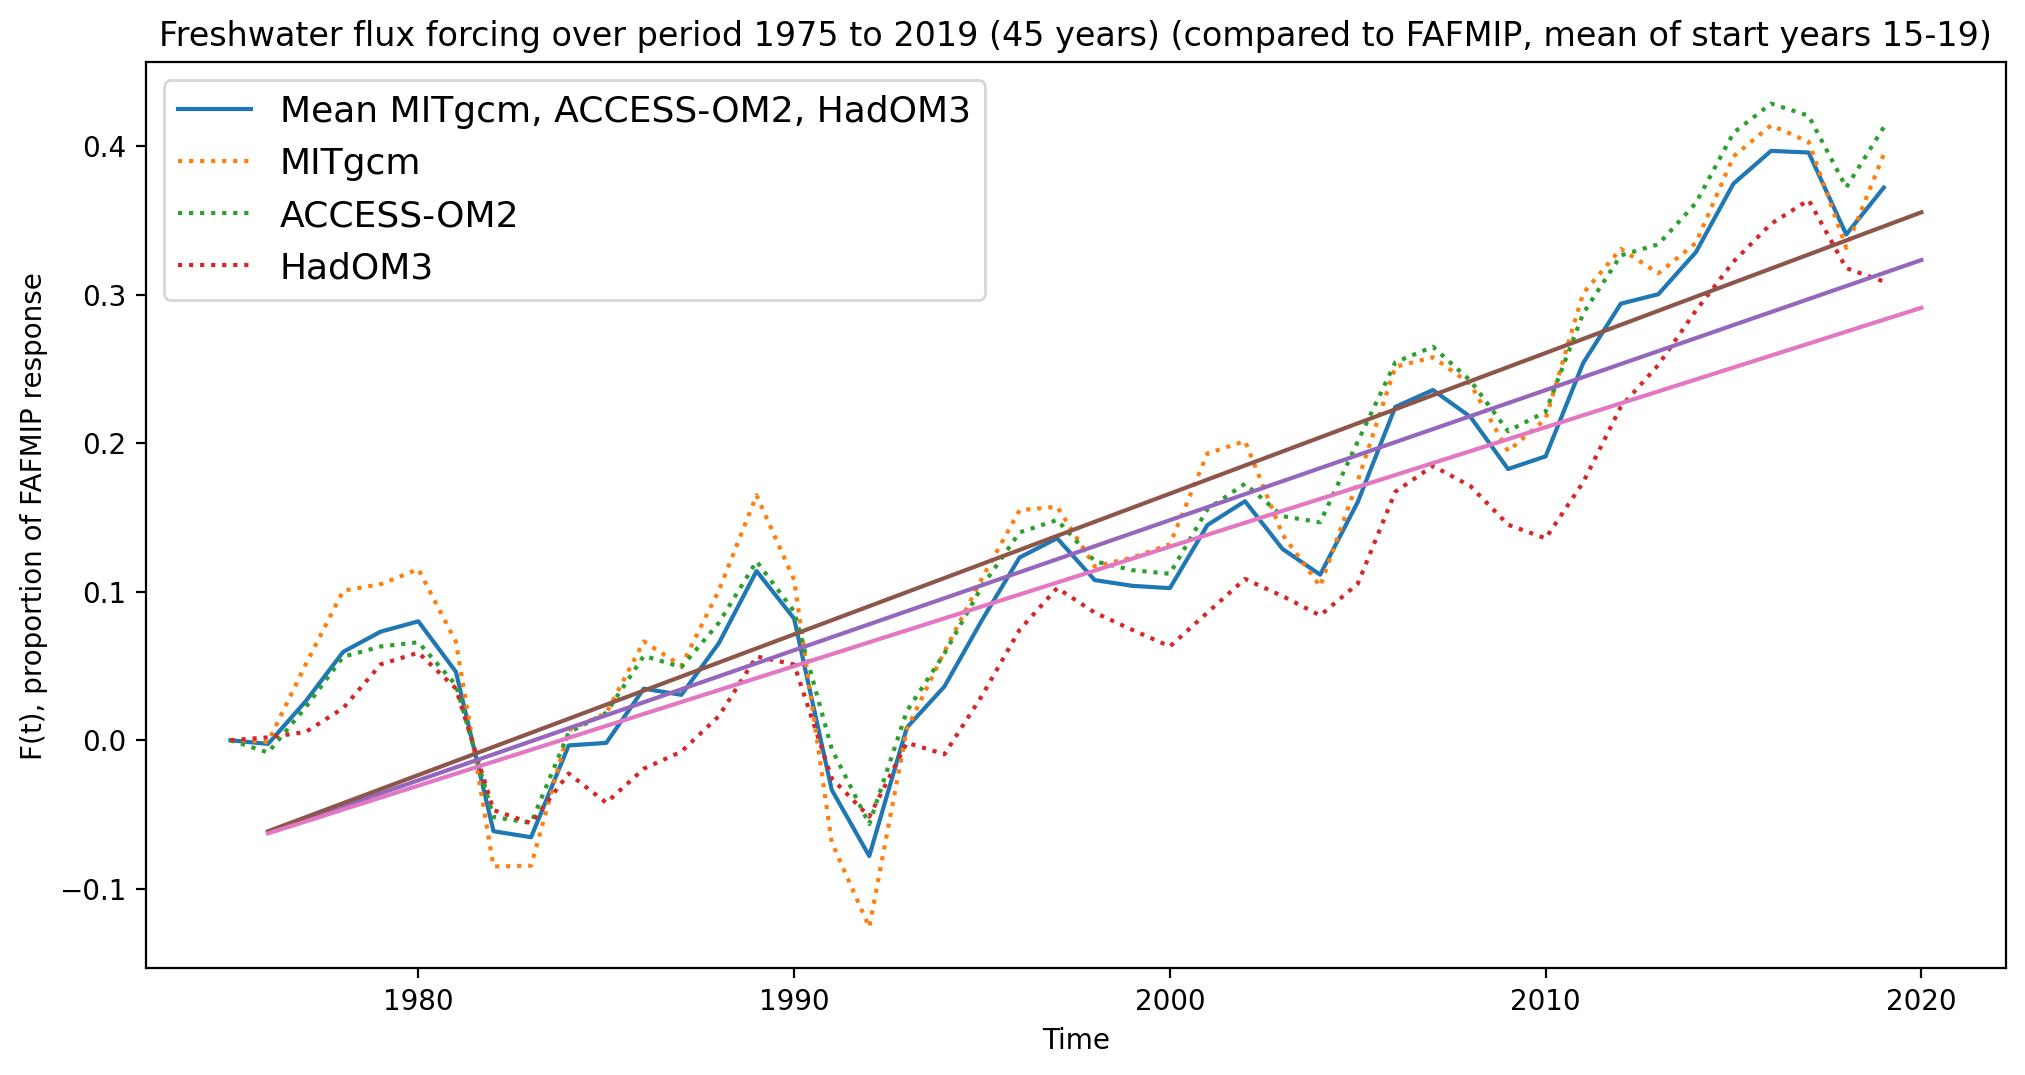

In [83]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,0])
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,0],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,1],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,2],':')
plt.title('Freshwater flux forcing over period 1975 to 2019 (45 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,0], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(p.slope*45+p.intercept)
print((p.slope-p.stderr)*45+p.intercept)
print((p.slope+p.stderr)*45+p.intercept)

0.3441761020746956


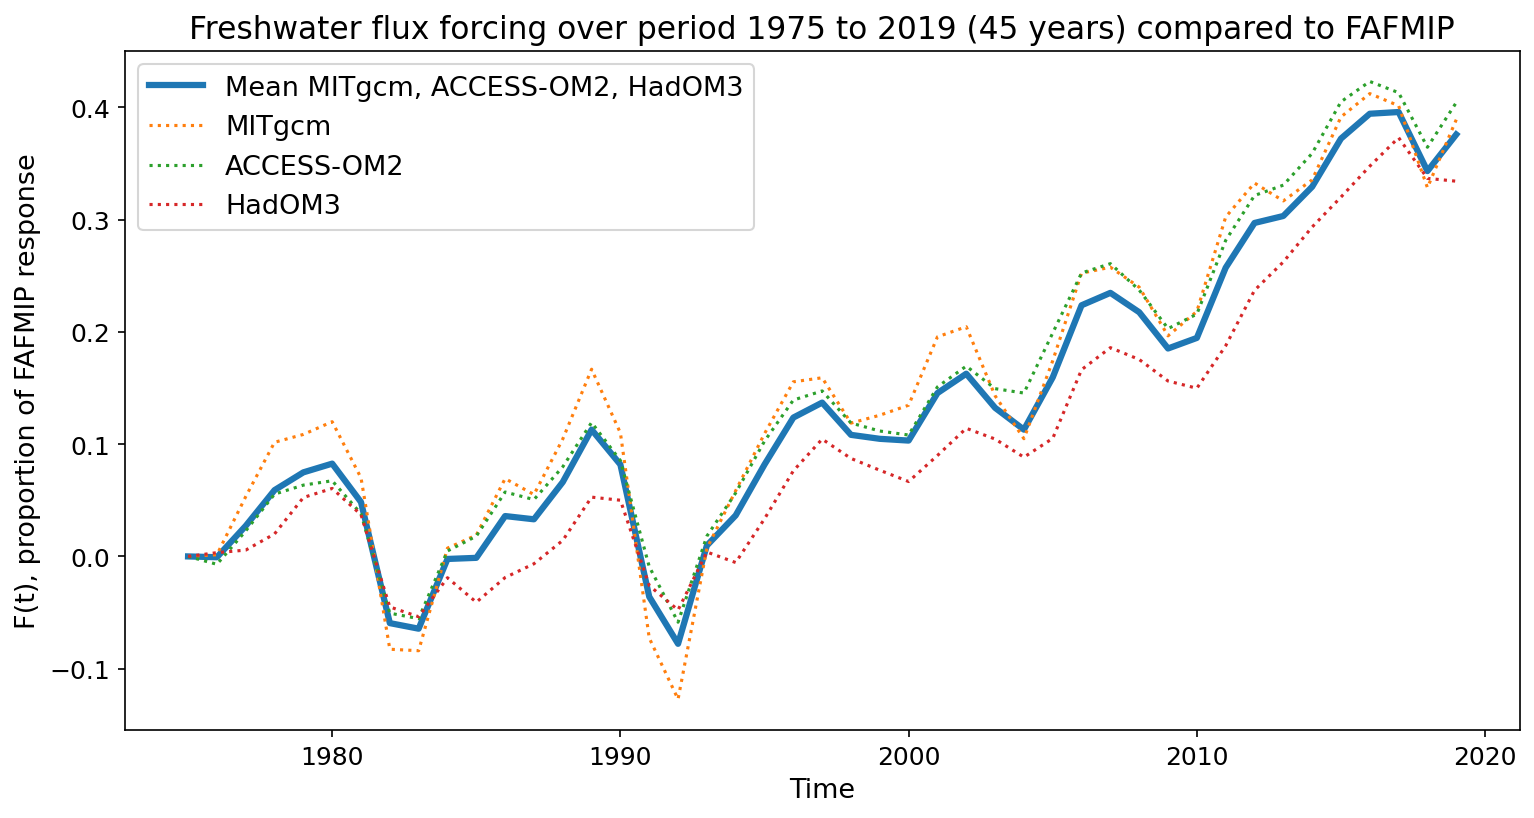

In [134]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150
#mpl.rcParams['figure.dpi'] = 300


from sklearn.linear_model import LinearRegression

fig,ax=plt.subplots(figsize=(12,6))


plt.rc('legend', fontsize=13)    # legend fontsize



plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,0],linewidth=3)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,0],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,1],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,2],':',linewidth=1.5)
plt.title('Freshwater flux forcing over period 1975 to 2019 (45 years) compared to FAFMIP',fontsize=15)
plt.xlabel('Time', fontsize=13)
plt.ylabel('F(t), proportion of FAFMIP response', fontsize=13)
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,0], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
#plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(df3_mean[40:45,0].mean()-df3_mean[0:5,0].mean())

0.3452800298777735


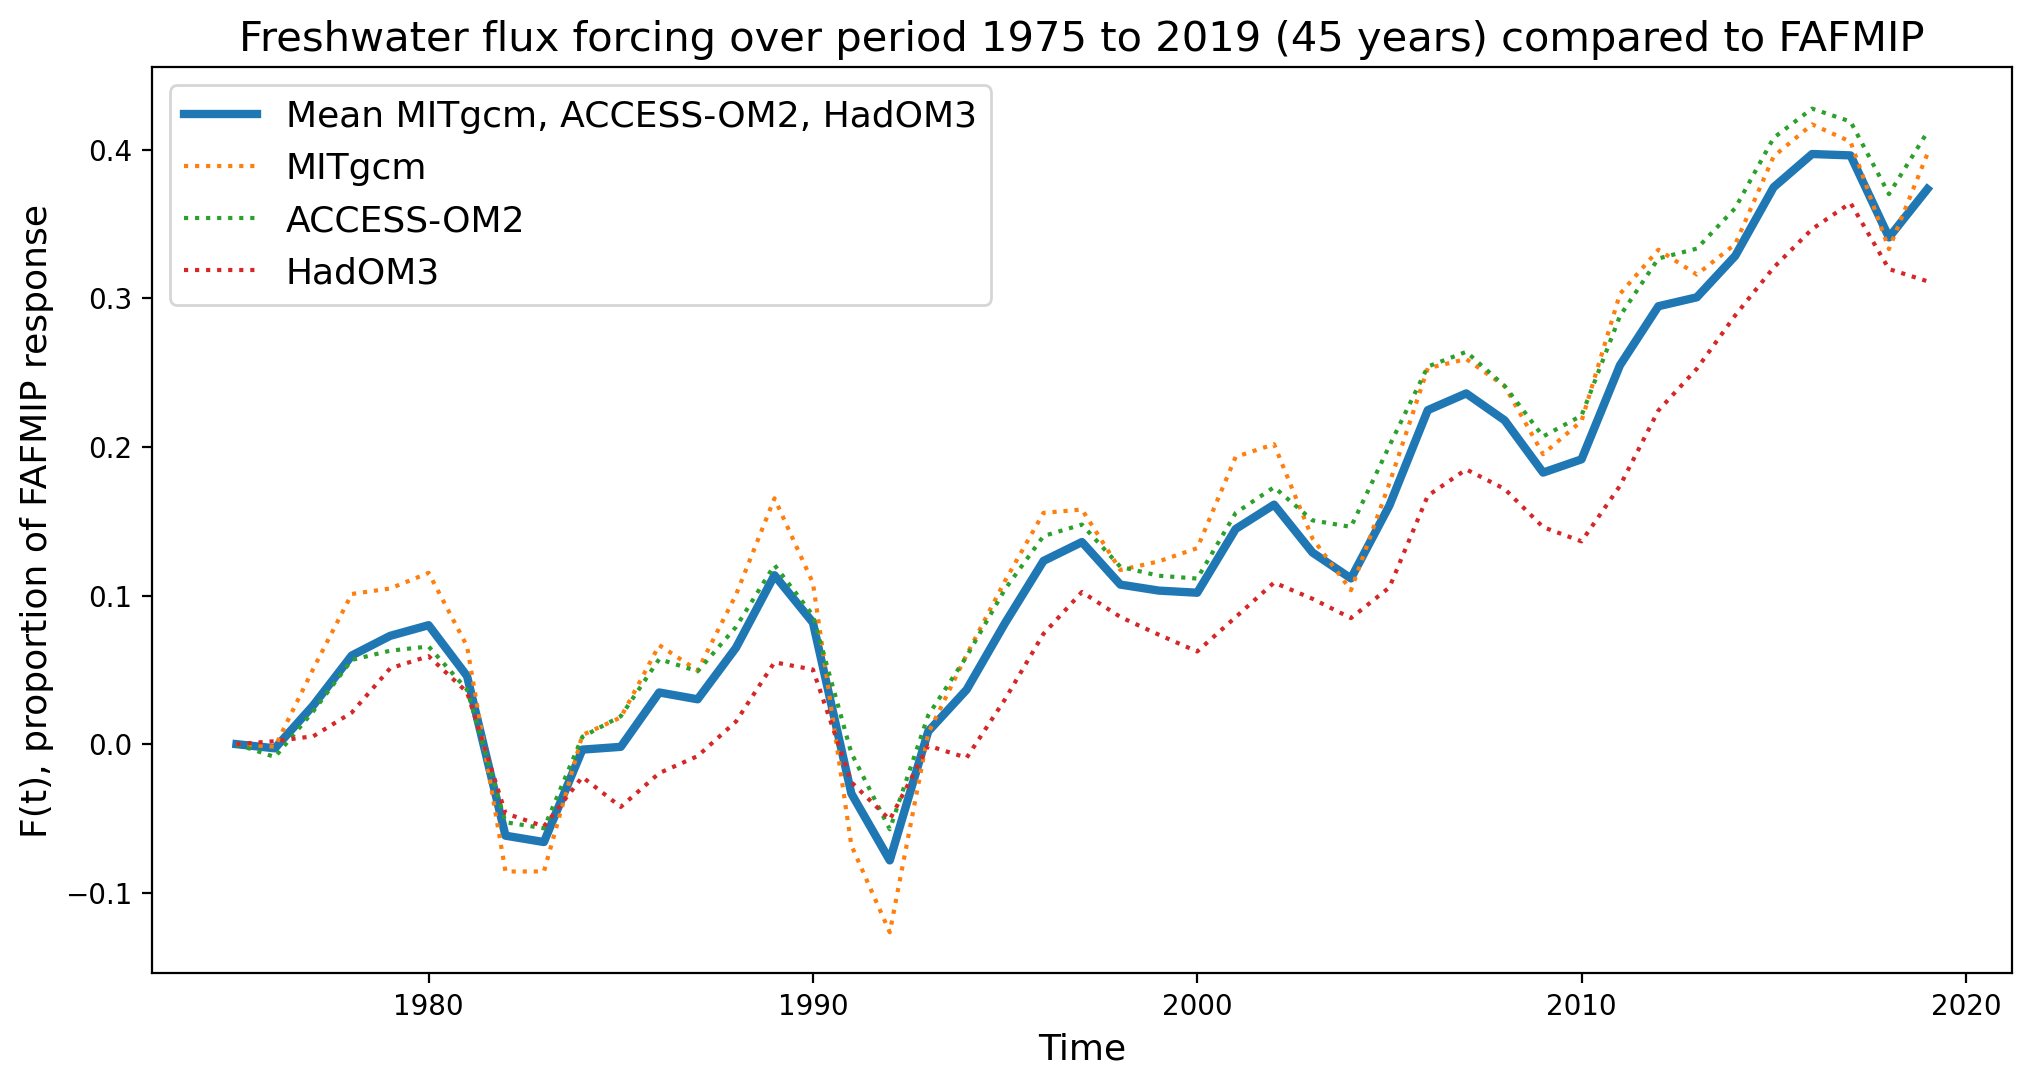

In [39]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150
#mpl.rcParams['figure.dpi'] = 300


from sklearn.linear_model import LinearRegression

fig,ax=plt.subplots(figsize=(12,6))


plt.rc('legend', fontsize=13)    # legend fontsize



plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,0],linewidth=3)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,0],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,1],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,2],':',linewidth=1.5)
plt.title('Freshwater flux forcing over period 1975 to 2019 (45 years) compared to FAFMIP',fontsize=15)
plt.xlabel('Time', fontsize=13)
plt.ylabel('F(t), proportion of FAFMIP response', fontsize=13)
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,0], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
#plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(df3_mean[40:45,0].mean()-df3_mean[0:5,0].mean())

0.34464541838319984


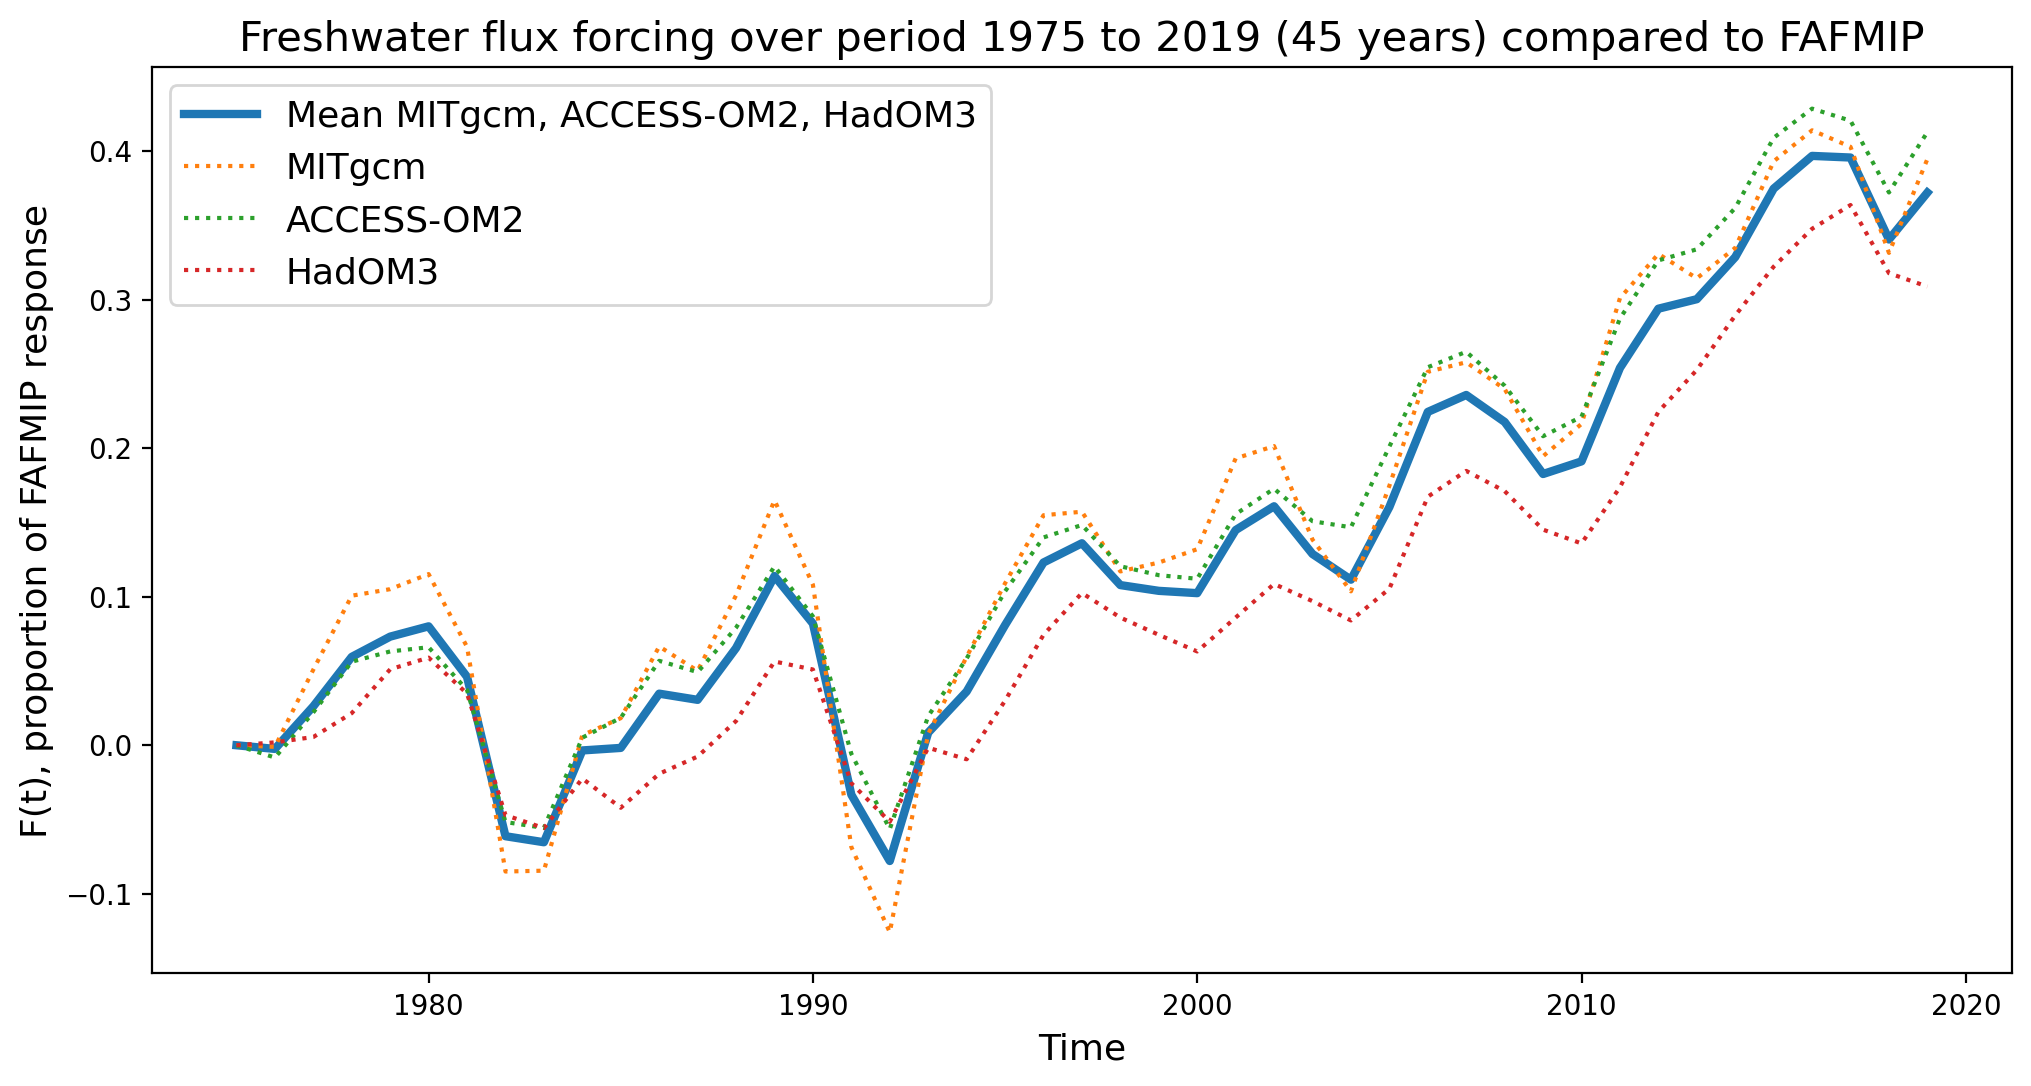

In [95]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150
#mpl.rcParams['figure.dpi'] = 300


from sklearn.linear_model import LinearRegression

fig,ax=plt.subplots(figsize=(12,6))


plt.rc('legend', fontsize=13)    # legend fontsize



plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,0],linewidth=3)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,0],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,1],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,2],':',linewidth=1.5)
plt.title('Freshwater flux forcing over period 1975 to 2019 (45 years) compared to FAFMIP',fontsize=15)
plt.xlabel('Time', fontsize=13)
plt.ylabel('F(t), proportion of FAFMIP response', fontsize=13)
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,0], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
#plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(df3_mean[40:45,0].mean()-df3_mean[0:5,0].mean())
response_mean_observables=df3_mean[40:45,0].mean()-df3_mean[0:5,0].mean()

0.6992863176710037
0.6658660276688732
0.7327066076731342


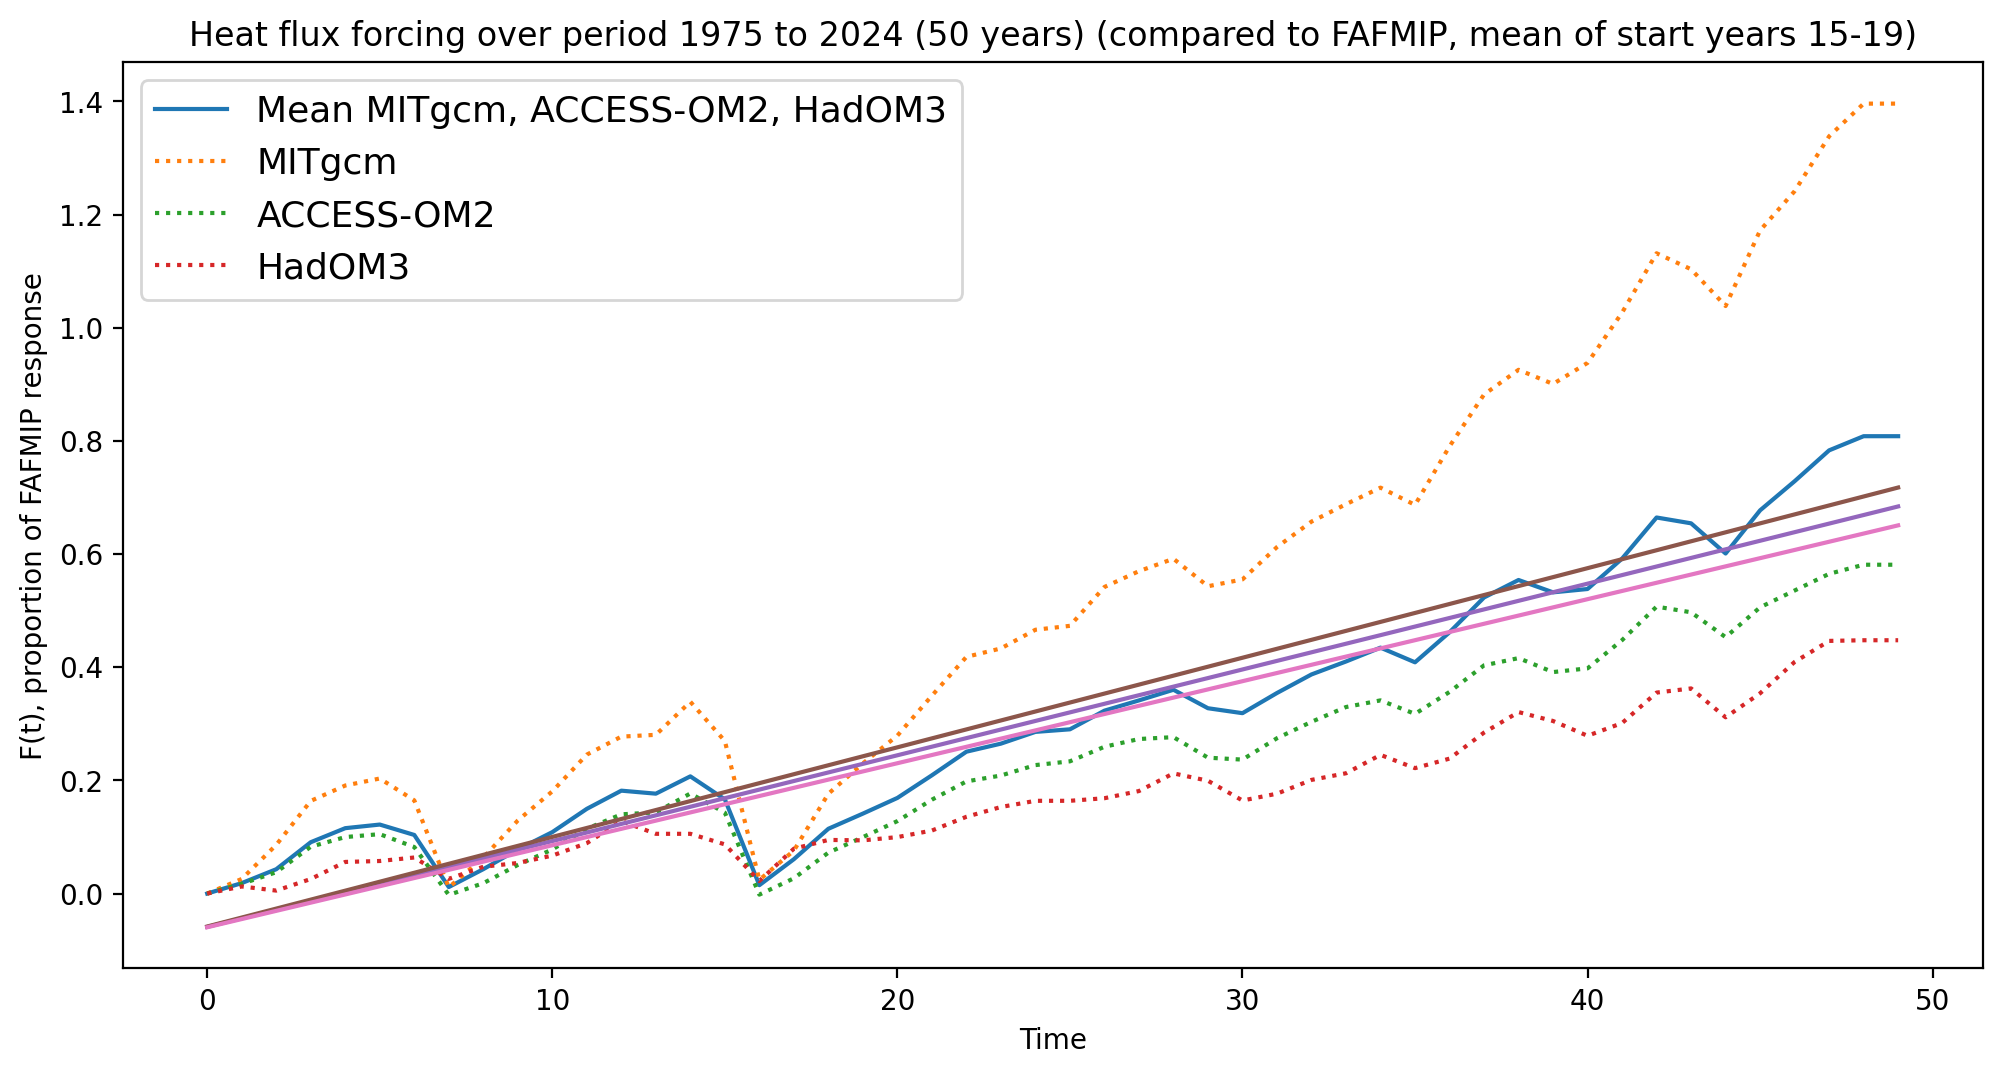

In [40]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(df3_mean[:,1])
plt.plot(df3[:,1,0],':')
plt.plot(df3[:,1,1],':')
plt.plot(df3[:,1,2],':')
plt.title('Heat flux forcing over period 1975 to 2024 (50 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,50,50), y=df3_mean[:,1], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
plt.plot(np.linspace(0,49,50), p.intercept + p.slope*np.linspace(0,49,50))
plt.plot(np.linspace(0,49,50), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,49,50))
plt.plot(np.linspace(0,49,50), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,49,50))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(p.slope*50+p.intercept)
print((p.slope-p.stderr)*50+p.intercept)
print((p.slope+p.stderr)*50+p.intercept)

0.5579356057291933


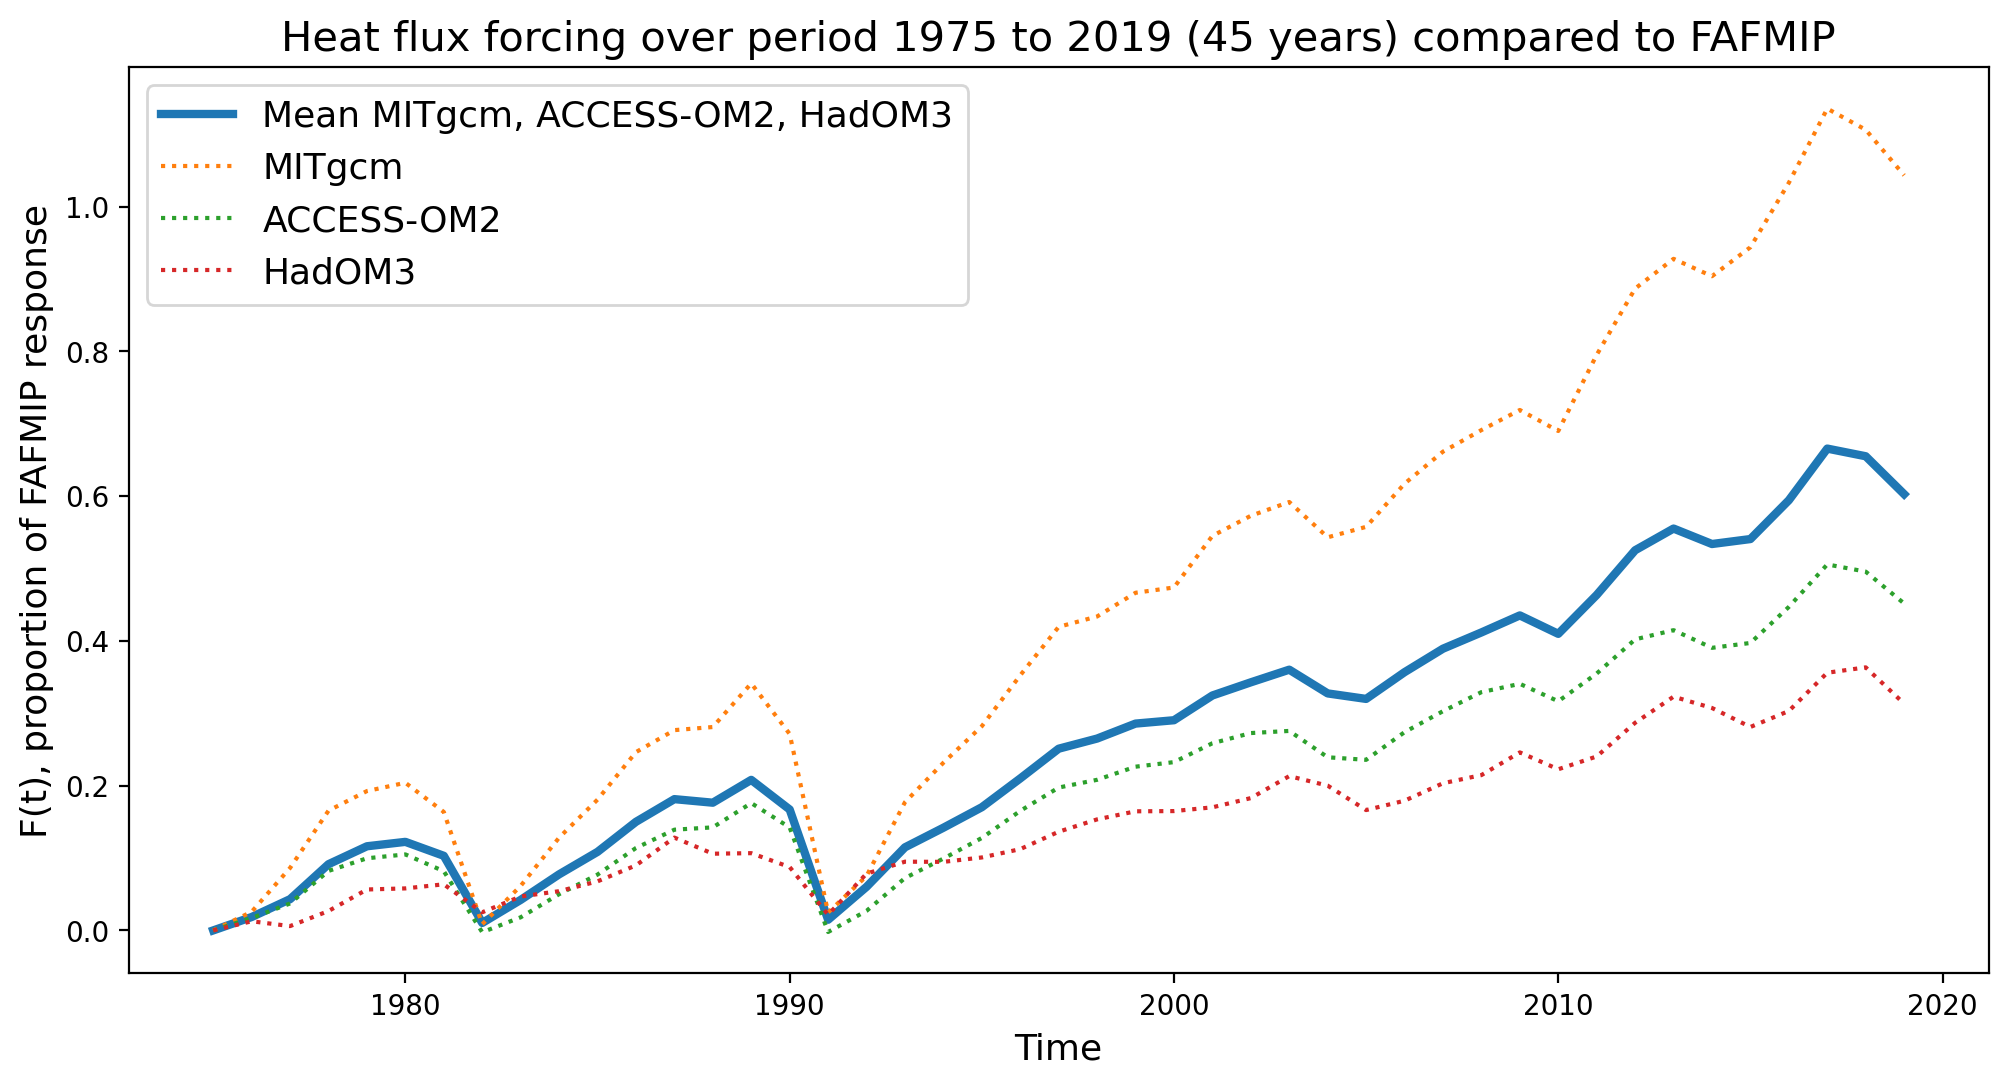

In [87]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150
#mpl.rcParams['figure.dpi'] = 300


from sklearn.linear_model import LinearRegression

fig,ax=plt.subplots(figsize=(12,6))


plt.rc('legend', fontsize=13)    # legend fontsize



plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,1],linewidth=3)
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,0],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,1],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,2],':',linewidth=1.5)
plt.title('Heat flux forcing over period 1975 to 2019 (45 years) compared to FAFMIP',fontsize=15)
plt.xlabel('Time', fontsize=13)
plt.ylabel('F(t), proportion of FAFMIP response', fontsize=13)
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,1], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
#plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(df3_mean[40:45,1].mean()-df3_mean[0:5,1].mean())

0.5804391388155121
0.5492943292644419
0.6115839483665824


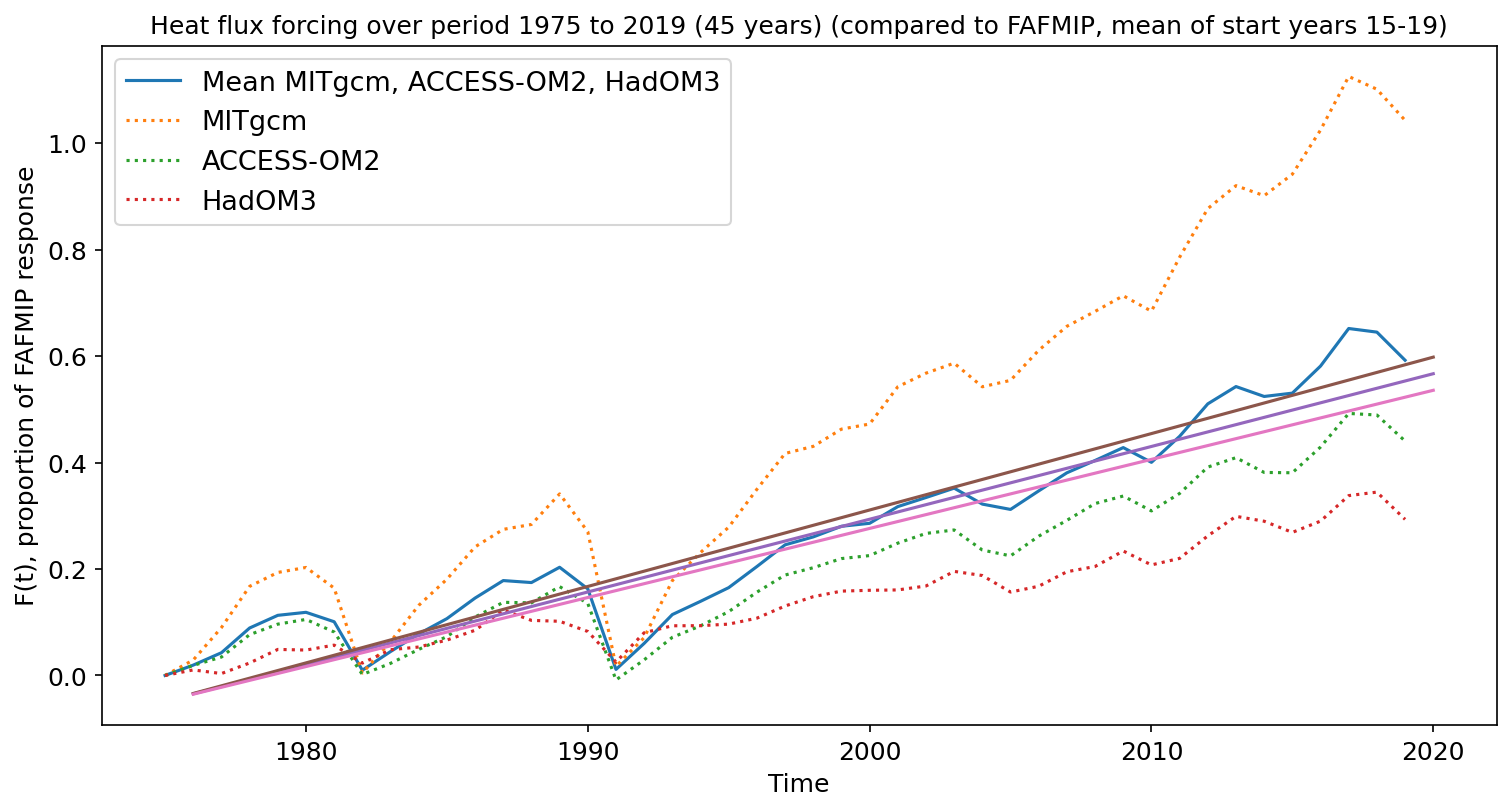

In [178]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,1])
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,0],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,1],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,2],':')
plt.title('Heat flux forcing over period 1975 to 2019 (45 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,1], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(p.slope*45+p.intercept)
print((p.slope-p.stderr)*45+p.intercept)
print((p.slope+p.stderr)*45+p.intercept)

0.5471626371518123


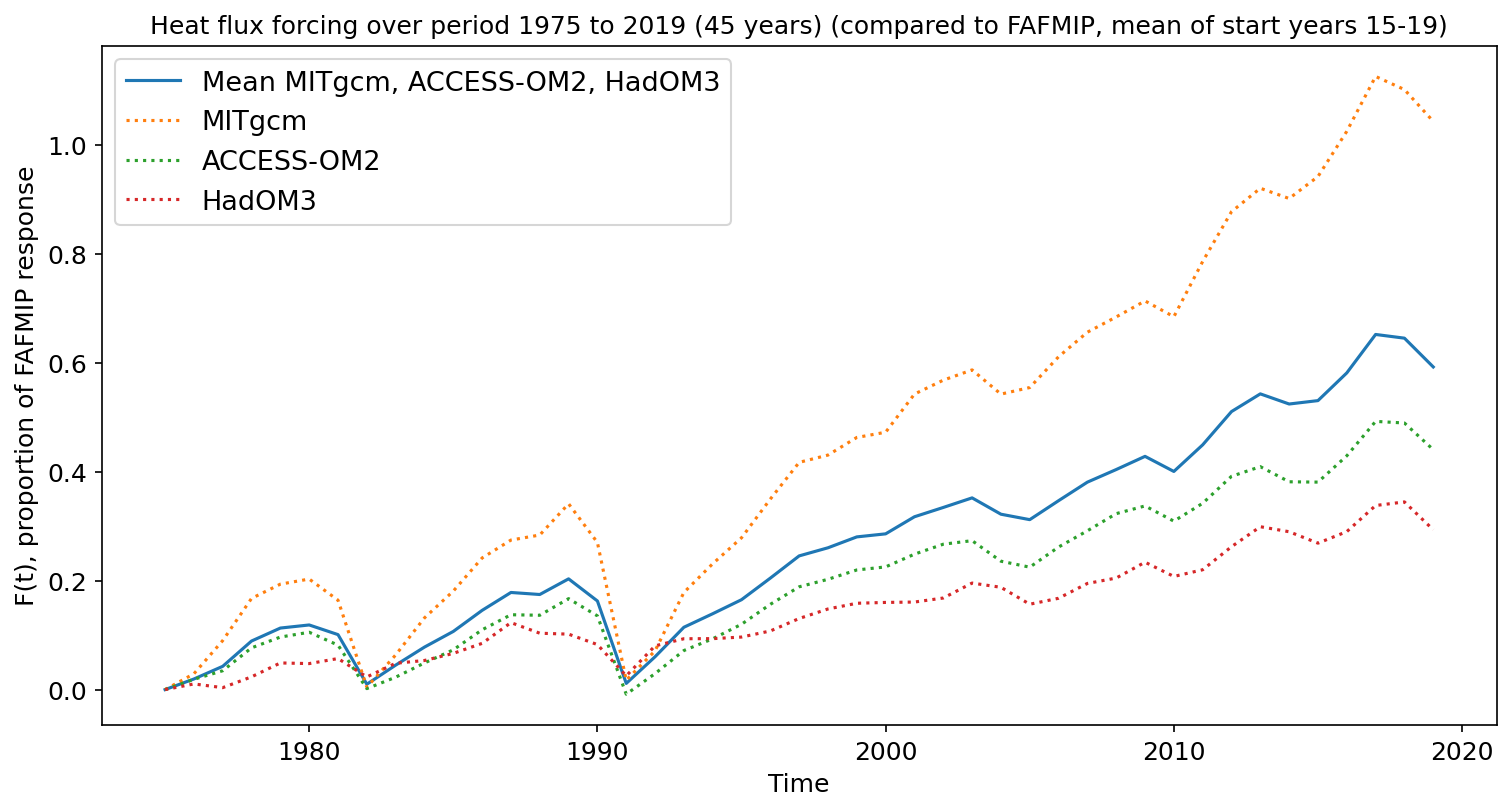

In [179]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,1])
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,0],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,1],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,1,2],':')
plt.title('Heat flux forcing over period 1975 to 2019 (45 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)

print(df3_mean[40:45,1].mean()-df3_mean[0:5,1].mean())

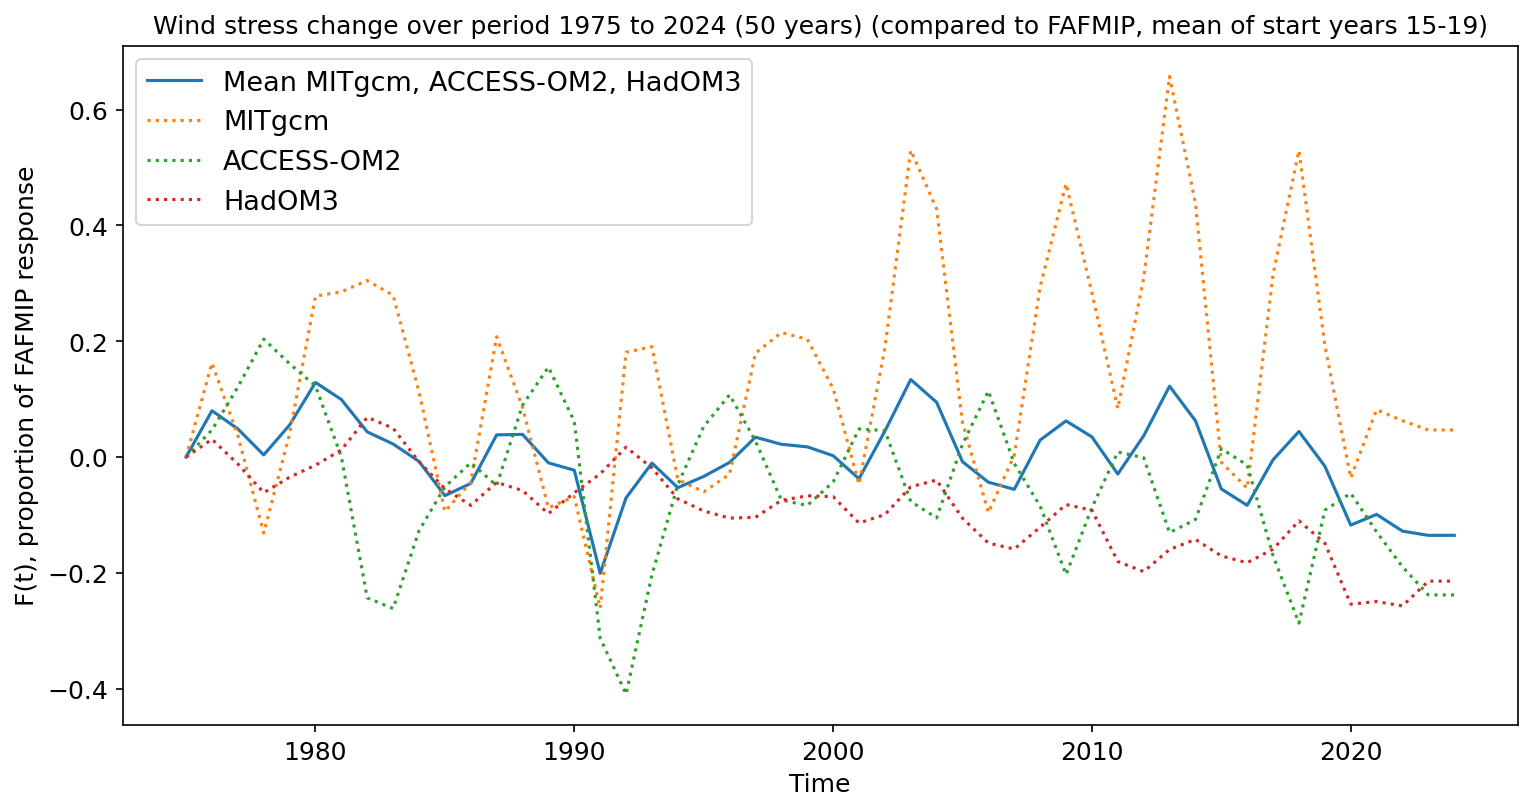

In [180]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(np.linspace(1975,2024,50),df3_mean[:,2])
plt.plot(np.linspace(1975,2024,50),df3[:,2,0],':')
plt.plot(np.linspace(1975,2024,50),df3[:,2,1],':')
plt.plot(np.linspace(1975,2024,50),df3[:,2,2],':')
plt.title('Wind stress change over period 1975 to 2024 (50 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

-0.0877145628753137


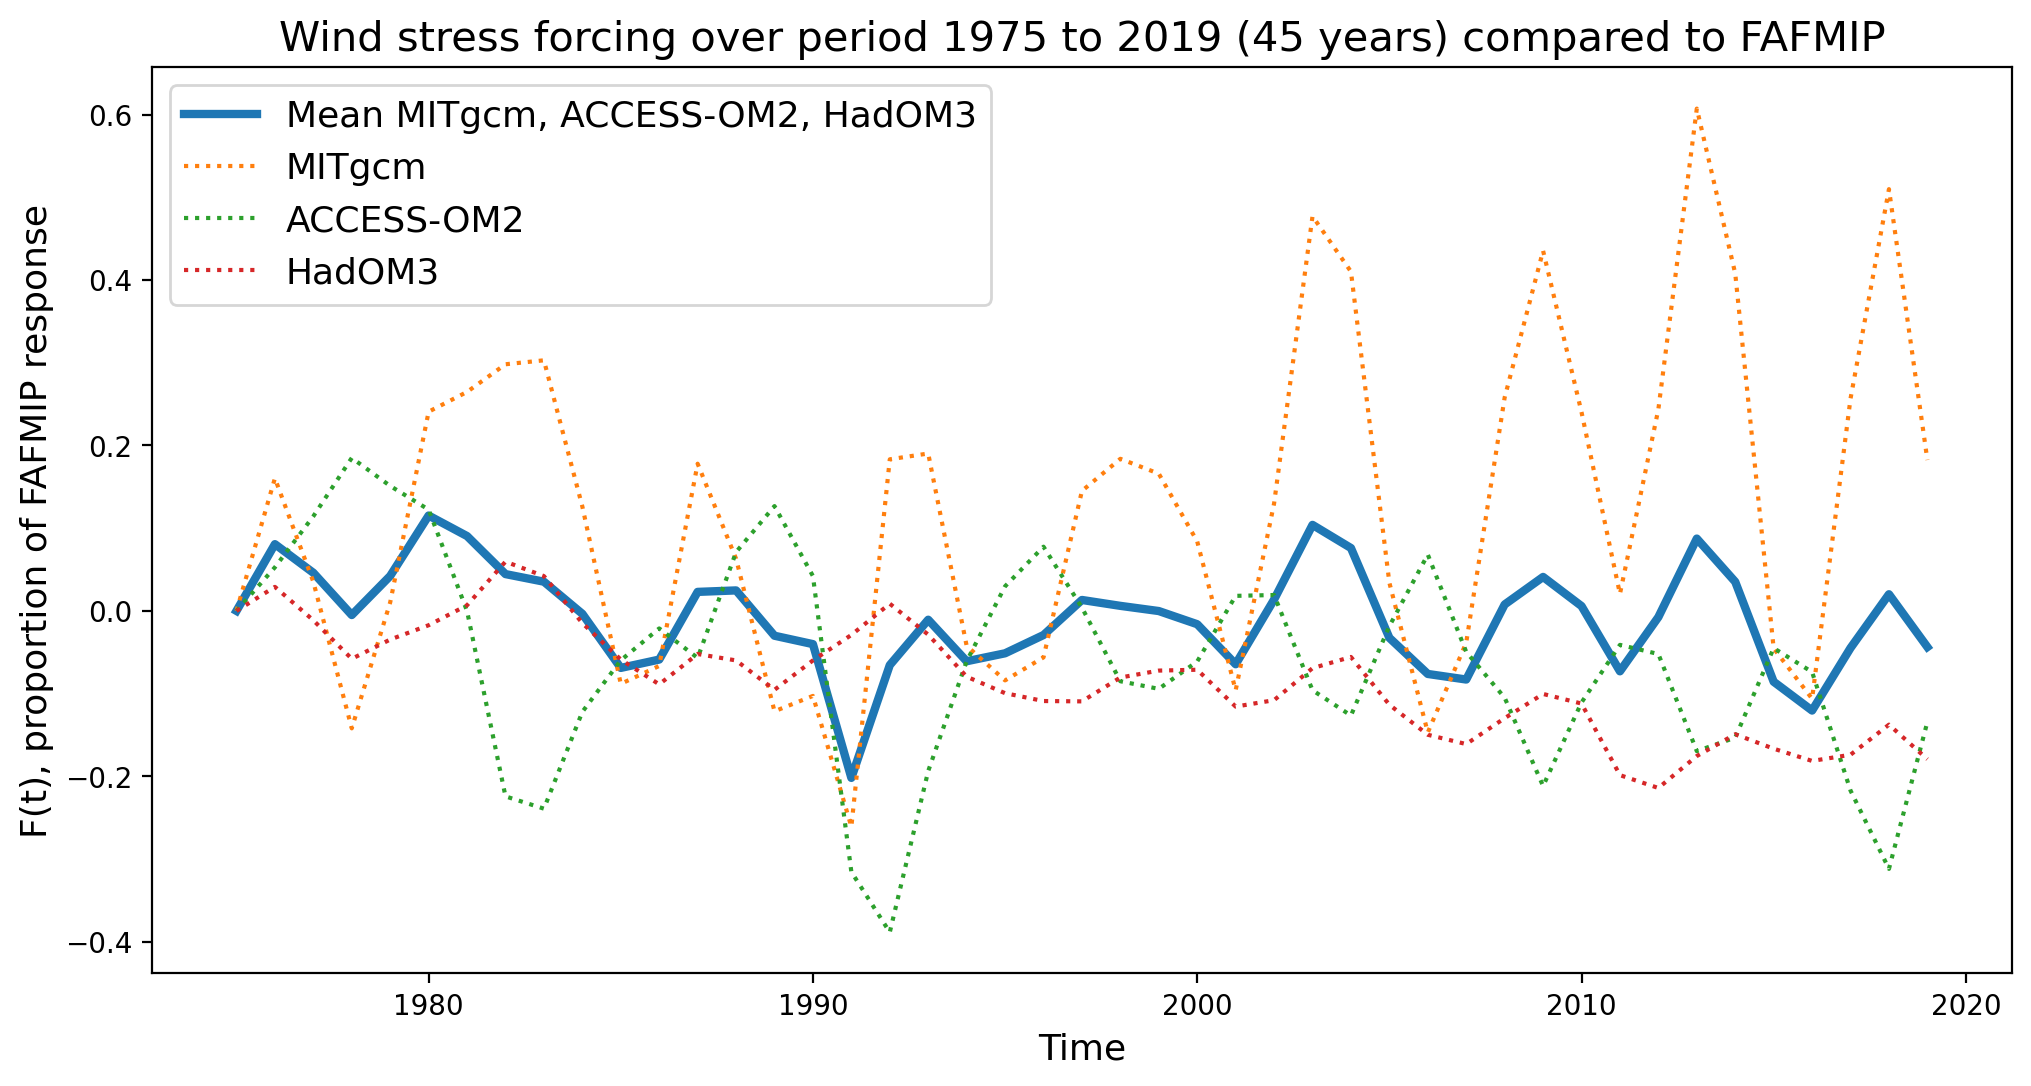

In [89]:
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 150
#mpl.rcParams['figure.dpi'] = 300


from sklearn.linear_model import LinearRegression

fig,ax=plt.subplots(figsize=(12,6))


plt.rc('legend', fontsize=13)    # legend fontsize



plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,2],linewidth=3)
plt.plot(np.linspace(1975,2019,45),df3[0:45,2,0],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,2,1],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,2,2],':',linewidth=1.5)
plt.title('Wind stress forcing over period 1975 to 2019 (45 years) compared to FAFMIP',fontsize=15)
plt.xlabel('Time', fontsize=13)
plt.ylabel('F(t), proportion of FAFMIP response', fontsize=13)
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

########## Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
##########
#plt.plot(p)



p=scipy.stats.linregress(np.linspace(0,44,45), y=df3_mean[0:45,2], alternative='two-sided')
# Spiffi Spuffi
#X = np.linspace(0,50,50).reshape((-1, 1))
#model=LinearRegression().fit(X, df3_mean[:,0])
#p = model.predict(X)
#
#print(p.pvalue)
#print(p.slope)
#print(p.slope-p.stderr)
#print(p.slope+p.stderr)
#plt.plot(np.linspace(1976,2020,45), p.intercept + p.slope*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept+p.stderr) + (p.slope+p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(1976,2020,45), (p.intercept-p.stderr) + (p.slope-p.stderr)*np.linspace(0,44,45))
#plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(df3_mean[40:45,2].mean()-df3_mean[0:5,2].mean())

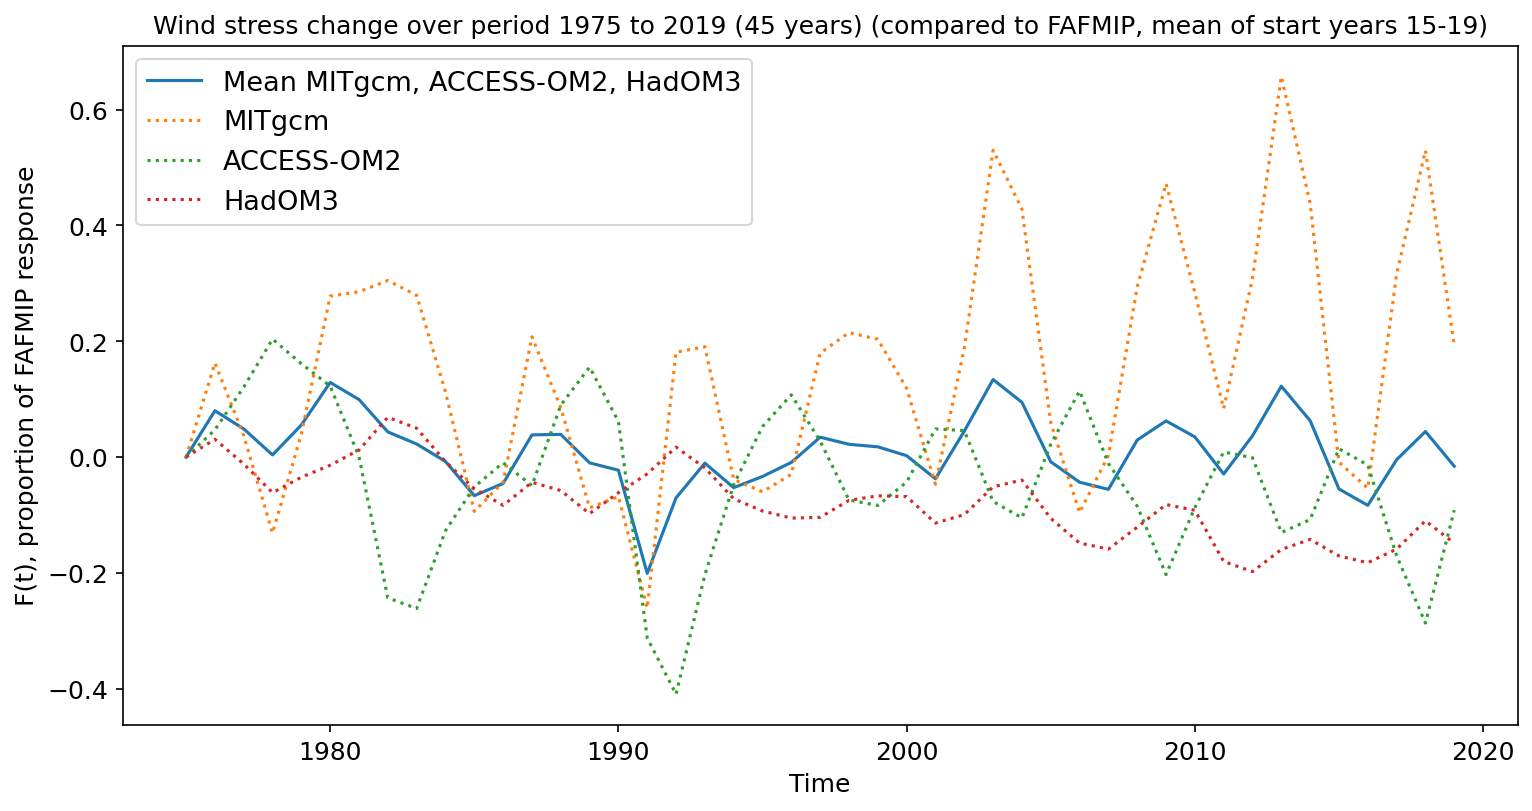

In [181]:
from sklearn.linear_model import LinearRegression
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,2])
plt.plot(np.linspace(1975,2019,45),df3[0:45,2,0],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,2,1],':')
plt.plot(np.linspace(1975,2019,45),df3[0:45,2,2],':')
plt.title('Wind stress change over period 1975 to 2019 (45 years) (compared to FAFMIP, mean of start years 15-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

In [71]:
from linear_response_functions import linear_response_list
%load_ext autoreload
%autoreload 2
change_water1, change_water_upper1, change_water_lower1,change_heat1,change_heat_upper1,change_heat_lower1=linear_response_list(salt_list,temp_list,salt_avg_1970to2020[0:45*12],n,a2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

In [90]:
from linear_response_functions import linear_response_list2
%load_ext autoreload
%autoreload 2
change_water2,change_heat2=linear_response_list2(salt_list,temp_list,salt_avg_1970to2020[0:45*12],n,a2) #this would find the individual member response based on regions found by the ensemble average

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

In [42]:
from linear_response_functions import linear_response_list2
%load_ext autoreload
%autoreload 2
change_water2,change_heat2=linear_response_list2(salt_list,temp_list,salt_list[0][0:45*12],n,a2) #this would find the individual member response where each time we recategorize the region of interest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

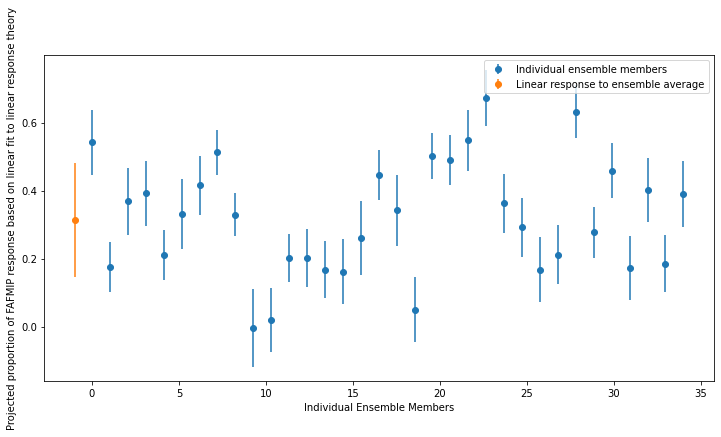

In [75]:
fig,ax=plt.subplots(figsize=(12,6))
r=np.linspace(0,34,34)
#ax.errorbar(r,np.sort(change_water1),yerr=[x for _, x in sorted(zip(change_water1, change_water_upper1))]-np.sort(change_water1),fmt="o")
ax.errorbar(r,change_water1,yerr=change_water_upper1-change_water1,fmt="o")
ax.errorbar(-1,weighted_stats.mean,yerr=weighted_stats.std,fmt="o")
ax.set_xlabel('Individual Ensemble Members')
ax.set_ylabel('Projected proportion of FAFMIP response based on linear fit to linear response theory')
ax.legend(['Individual ensemble members','Linear response to ensemble average'])

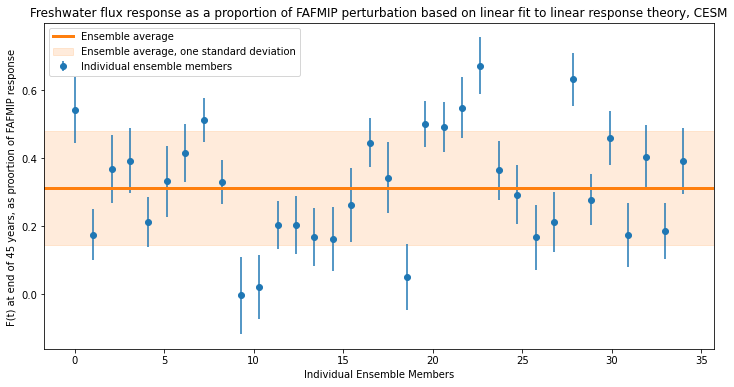

In [78]:
fig,ax=plt.subplots(figsize=(12,6))
r=np.linspace(0,34,34)
#ax.errorbar(r,np.sort(change_water1),yerr=[x for _, x in sorted(zip(change_water1, change_water_upper1))]-np.sort(change_water1),fmt="o")
ax.errorbar(r,change_water1,yerr=change_water_upper1-change_water1,fmt="o",label='Individual ensemble members')
ax.axhline(weighted_stats.mean,color='tab:orange',label='Ensemble average',linewidth=3)
#ax.fill_between((weighted_stats.mean-weighted_stats.std)*np.ones(34), (weighted_stats.mean+weighted_stats.std)*np.ones(34), color='tab:orange', alpha=0.5)
ax.axhspan((weighted_stats.mean-weighted_stats.std), (weighted_stats.mean+weighted_stats.std), alpha=0.15, color='tab:orange',label='Ensemble average, one standard deviation')
#ax.errorbar(r,weighted_stats.mean,yerr=weighted_stats.std,fmt="o")
ax.set_xlabel('Individual Ensemble Members')
ax.set_ylabel('F(t) at end of 45 years, as proortion of FAFMIP response ')
ax.set_title('Freshwater flux response as a proportion of FAFMIP perturbation based on linear fit to linear response theory, CESM')
ax.legend()
#ax.legend(['Individual ensemble members','Linear response to ensemble average','Linear response to ensemble average 1 std deviation'])

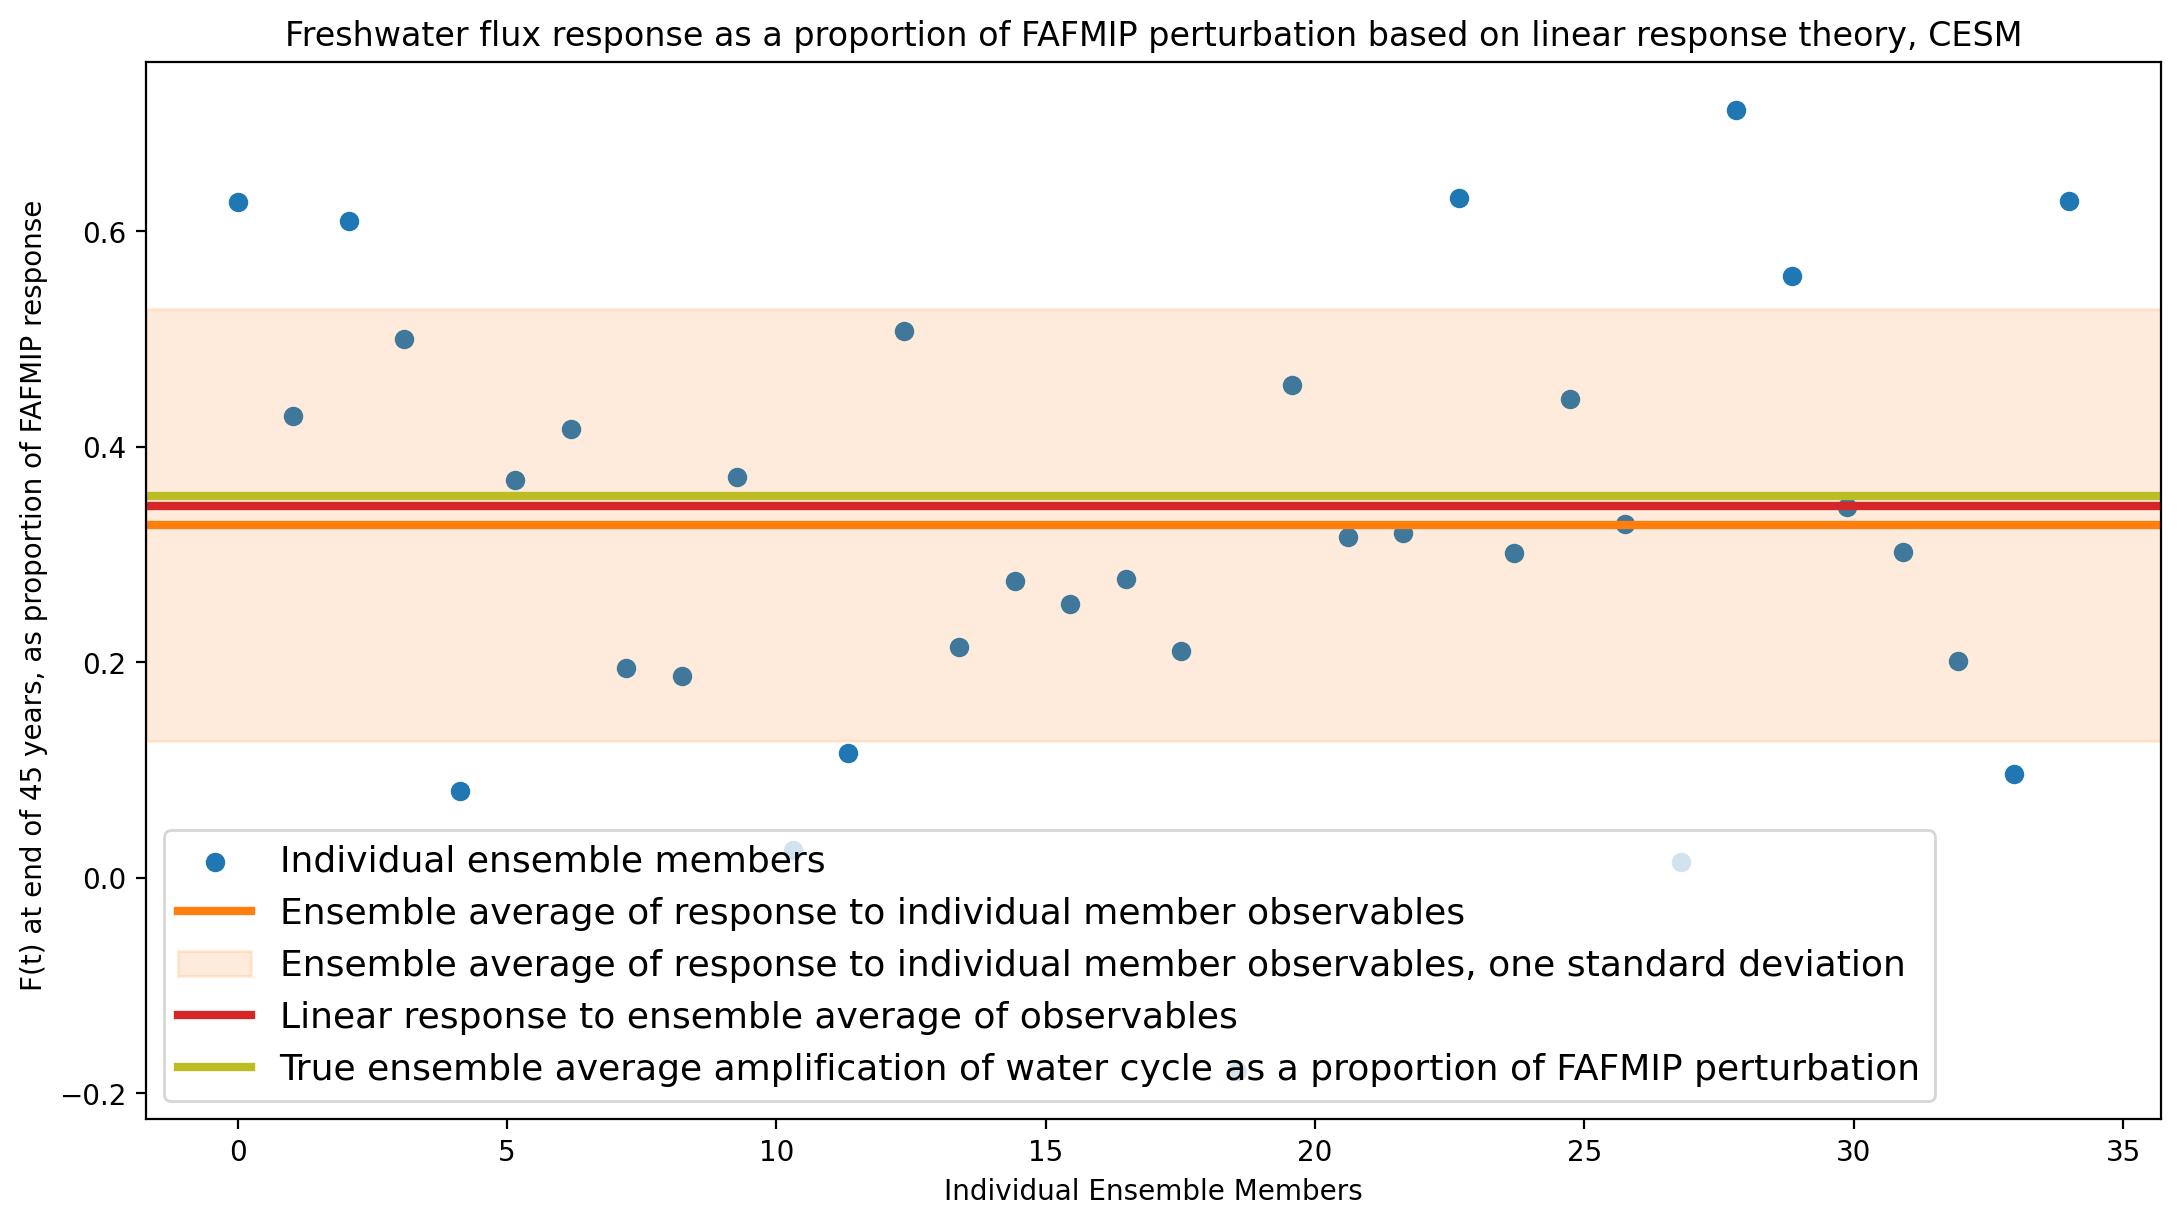

In [47]:
fig,ax=plt.subplots(figsize=(13,7))
r=np.linspace(0,34,34)
#ax.errorbar(r,np.sort(change_water1),yerr=[x for _, x in sorted(zip(change_water1, change_water_upper1))]-np.sort(change_water1),fmt="o")
ax.scatter(r,change_water2,label='Individual ensemble members')
ax.axhline(mean2,color='tab:orange',label='Ensemble average of response to individual member observables',linewidth=3)
#ax.fill_between((weighted_stats.mean-weighted_stats.std)*np.ones(34), (weighted_stats.mean+weighted_stats.std)*np.ones(34), color='tab:orange', alpha=0.5)
ax.axhspan((mean2-std2), (mean2+std2), alpha=0.15, color='tab:orange',label='Ensemble average of response to individual member observables, one standard deviation')
ax.axhline(response_mean_observables,color='tab:red',label='Linear response to ensemble average of observables',linewidth=3)
#ax.axhline(0.34022083, color='tab:olive',label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation',linewidth=3)
ax.axhline(0.35491687, color='tab:olive',label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation',linewidth=3)
#ax.errorbar(r,weighted_stats.mean,yerr=weighted_stats.std,fmt="o")
ax.set_xlabel('Individual Ensemble Members')
ax.set_ylabel('F(t) at end of 45 years, as proportion of FAFMIP response ')
ax.set_title('Freshwater flux response as a proportion of FAFMIP perturbation based on linear response theory, CESM')
ax.legend()
#ax.legend(['Individual ensemble members','Linear response to ensemble average','Linear response to ensemble average 1 std deviation'])

In [169]:
from statsmodels.stats.weightstats import DescrStatsW
weighted_stats = DescrStatsW(change_water1, weights=change_water_upper1-change_water1, ddof=0)
print(weighted_stats.mean)
print(weighted_stats.std)

0.3130276839048676
0.16763818901493438


In [29]:
o=change_water1-weighted_stats.mean
within_error = (np.abs(o) < weighted_stats.std).sum() #this counts how many of the ensemble members are within the error bound
print(within_error)
print(within_error/34)

24
0.7058823529411765


In [28]:
o=change_water1-weighted_stats.mean
within_error_2times = (np.abs(o) < 1.96*weighted_stats.std).sum() #this counts how many of the ensemble members are within the error bound
print(within_error_2times)
print(within_error_2times/34)

31
0.9117647058823529


In [43]:
mean2=change_water2.mean()
std2=change_water2.std()

In [172]:
mean1=change_water1.mean()
std1=change_water1.std()
print(mean1)
print(std1)

0.3207243353478575
0.16659580895436102


In [167]:
print(mean2)
print(std2)

0.32200830865310454
0.22150336573884774


In [44]:
print(mean2)
print(std2)

0.3279117772332607
0.20046240796556422


Text(0.5, 1.0, 'Change in salinity in each region CESM from convolution from wind stress change')

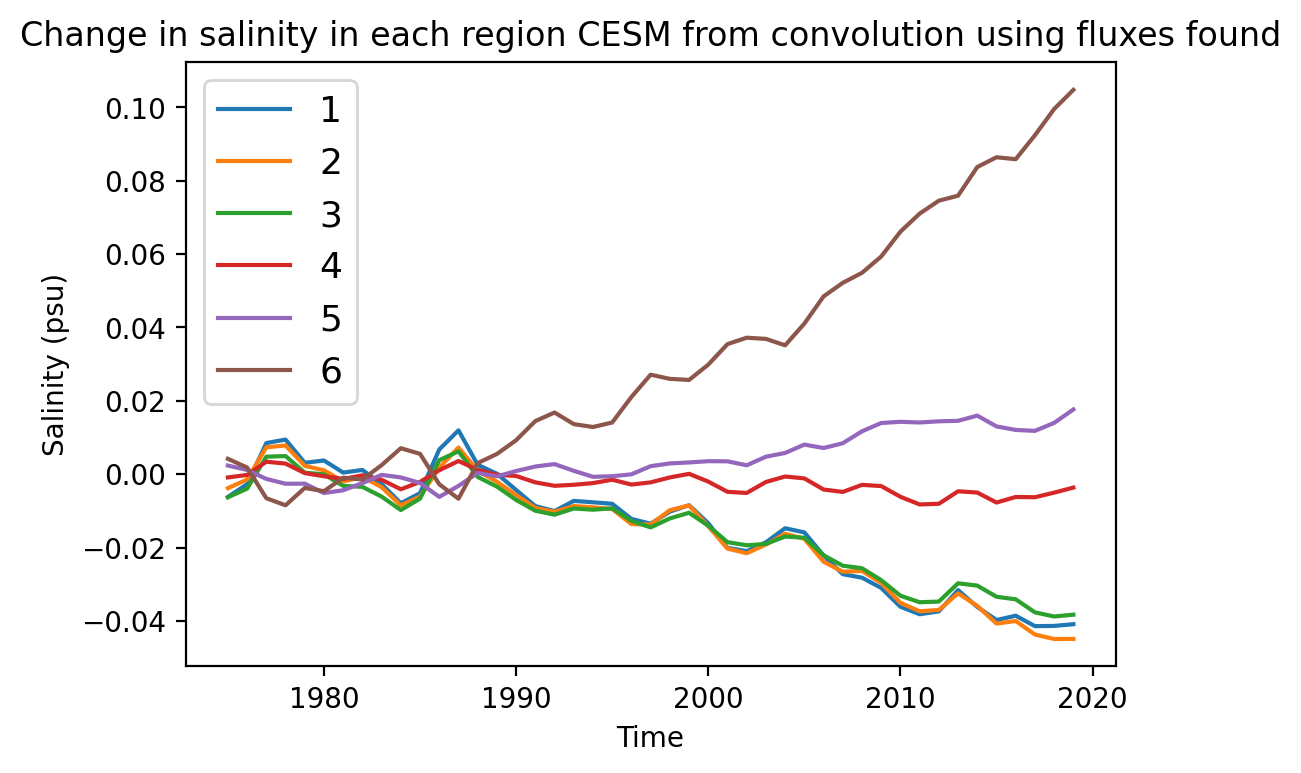

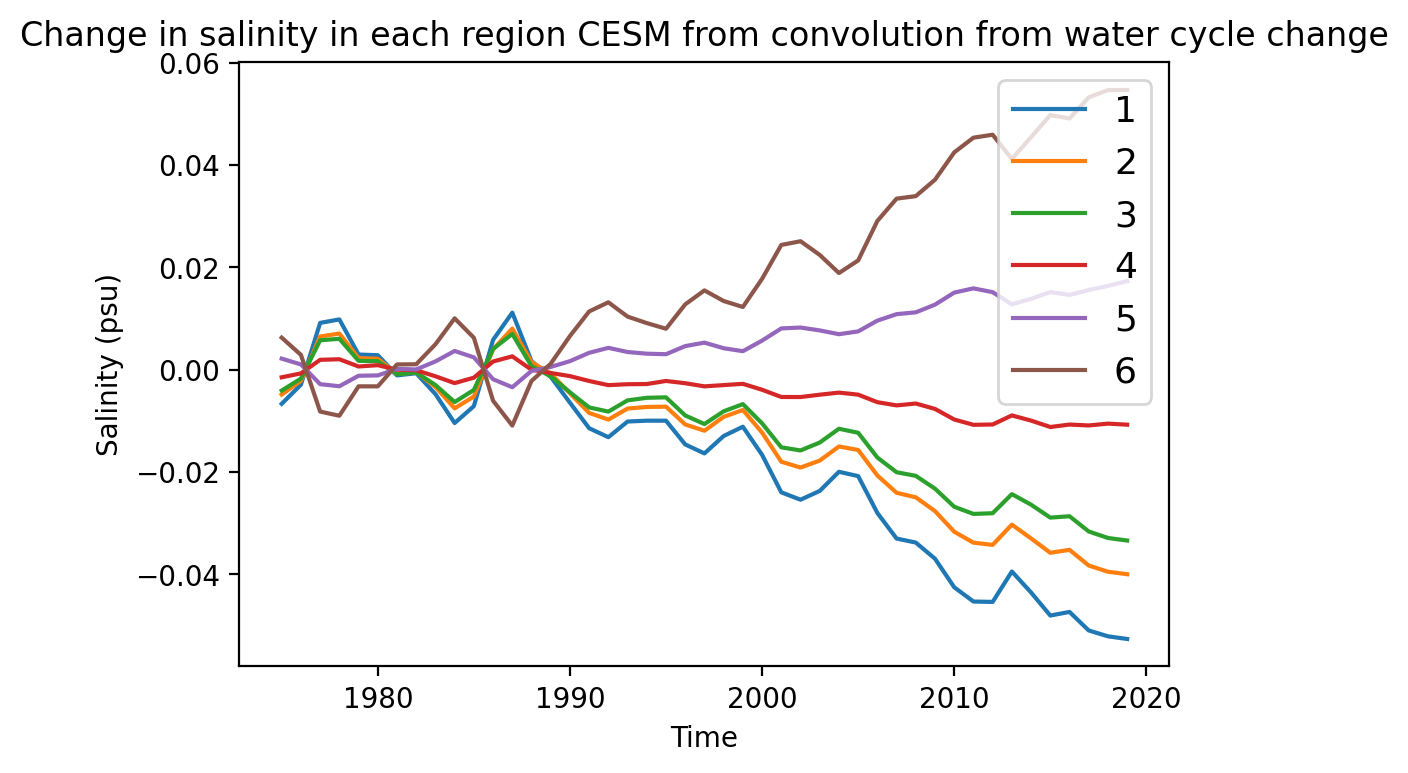

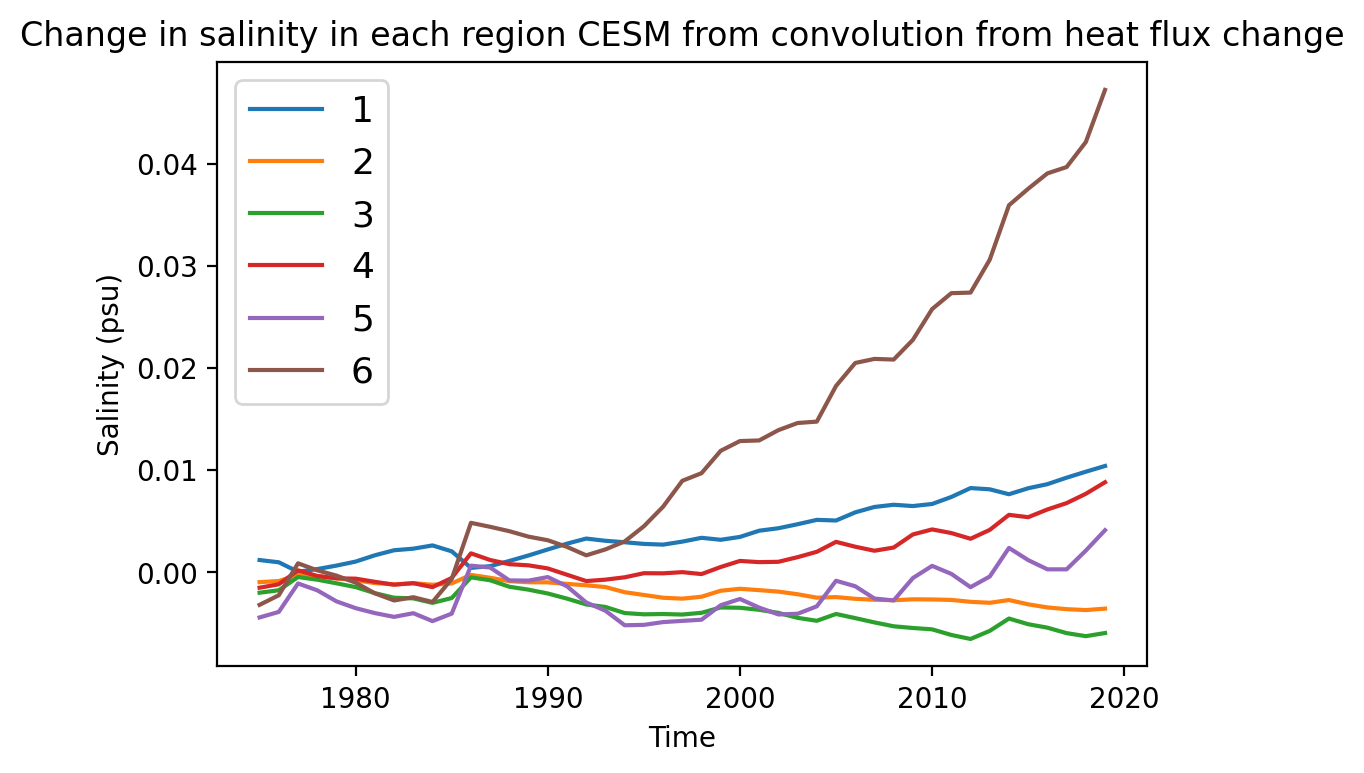

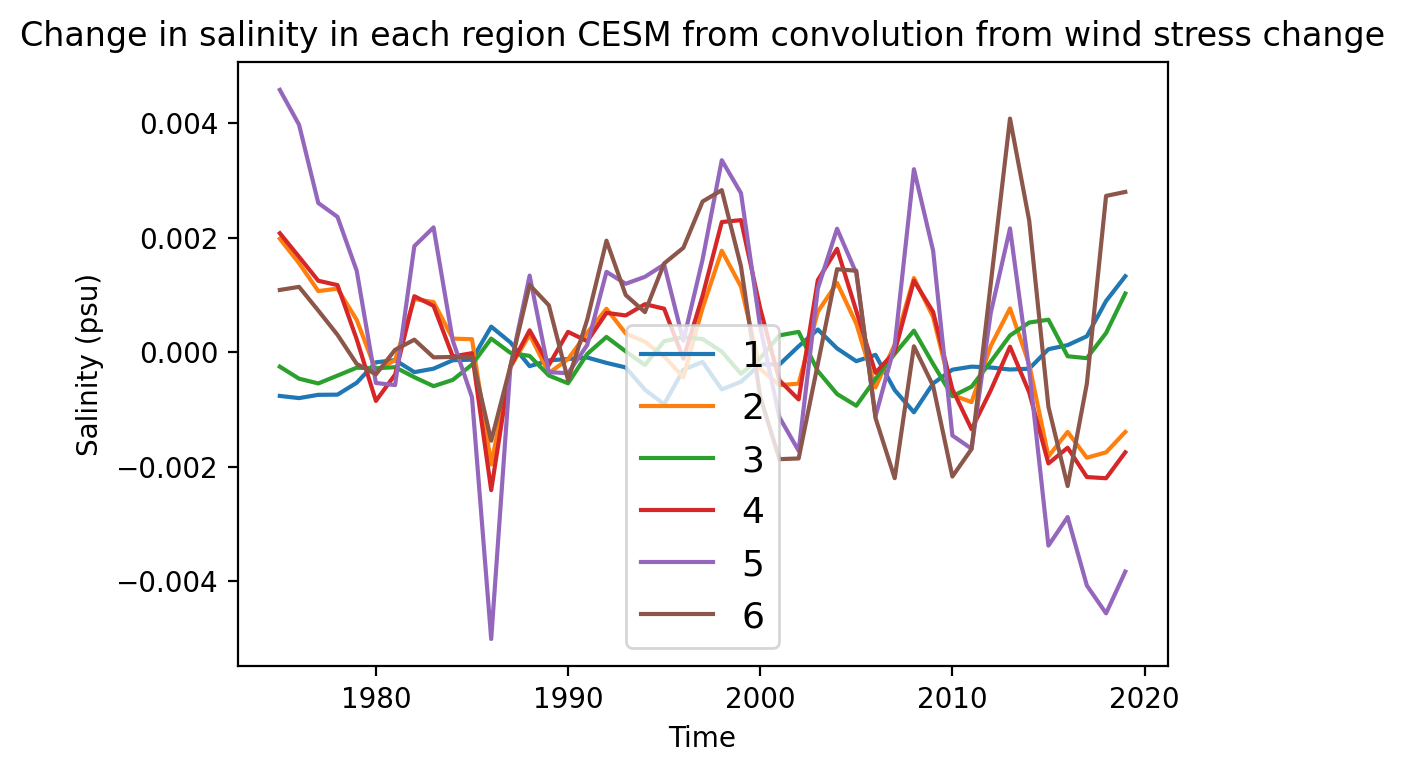

In [32]:
#We can now use the answer we found and convolve with the FAFMIP response to see if we recover close to the CESM2 response
change_water_mit=salt_mit_water[:,:]-salt_mit_water[0,:]
change_heat_mit=salt_mit_heat[:,:]-salt_mit_heat[0,:]
change_stress_mit=salt_mit_stress[:,:]-salt_mit_stress[0,:]

change_water_access=salt_access_water[:,:]-salt_access_water[0,:]
change_heat_access=salt_access_heat[:,:]-salt_access_heat[0,:]
change_stress_access=salt_access_stress[:,:]-salt_access_stress[0,:]

change_water_had=salt_had_water[:,:]-salt_had_water[0,:]
change_heat_had=salt_had_heat[:,:]-salt_had_heat[0,:]
change_stress_had=salt_had_stress[:,:]-salt_had_stress[0,:]

#change_water=np.mean([change_water_had[19:70],change_water_mit[19:70]],axis=0)
#change_heat=np.mean([change_heat_had[19:70],change_heat_mit[19:70]],axis=0)
#change_stress=np.mean([change_stress_had[19:70],change_stress_mit[19:70]],axis=0)


change_water=np.mean([change_water_access[16:67],change_water_mit[16:67]],axis=0)
change_heat=np.mean([change_heat_access[16:67],change_heat_mit[16:67]],axis=0)
change_stress=np.mean([change_stress_access[16:67],change_stress_mit[16:67]],axis=0)

change_fafmip=np.stack((change_water,change_heat,change_stress))

df_new=np.mean(np.mean(df,axis=1),axis=2)
#np.mean(df,axis=1)[:,:,1]


conv=np.zeros([3,50,n])
conv2=np.zeros([3,50,n])
for p in range(0,3):
    for k in range(0,n):
        for i in range(0,50):
            sum=0
            for j in range(0,i+1):
                sum=(change_fafmip[p,i-j,k])*df_new[j,p]+sum #mit0,access1,had2 #FIX THIS, THIS ISNT QUITE RIGHT. WANT TO MULTIPLY WITH THE TIME DERIV VERSION AND THEN SUM INSTEAD OF SUMMED DERIV
            conv[p,i,k]=sum
            conv2[:,i,k]=conv[:,i,k].cumsum(axis=0)

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),np.sum(conv,axis=0)[5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region CESM from convolution using fluxes found')

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),conv[0,5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region CESM from convolution from water cycle change')

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),conv[1,5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region CESM from convolution from heat flux change')

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),conv[2,5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region CESM from convolution from wind stress change')

Text(0.5, 1.0, 'Change in temperature in each region CESM from convolution from wind stress change')

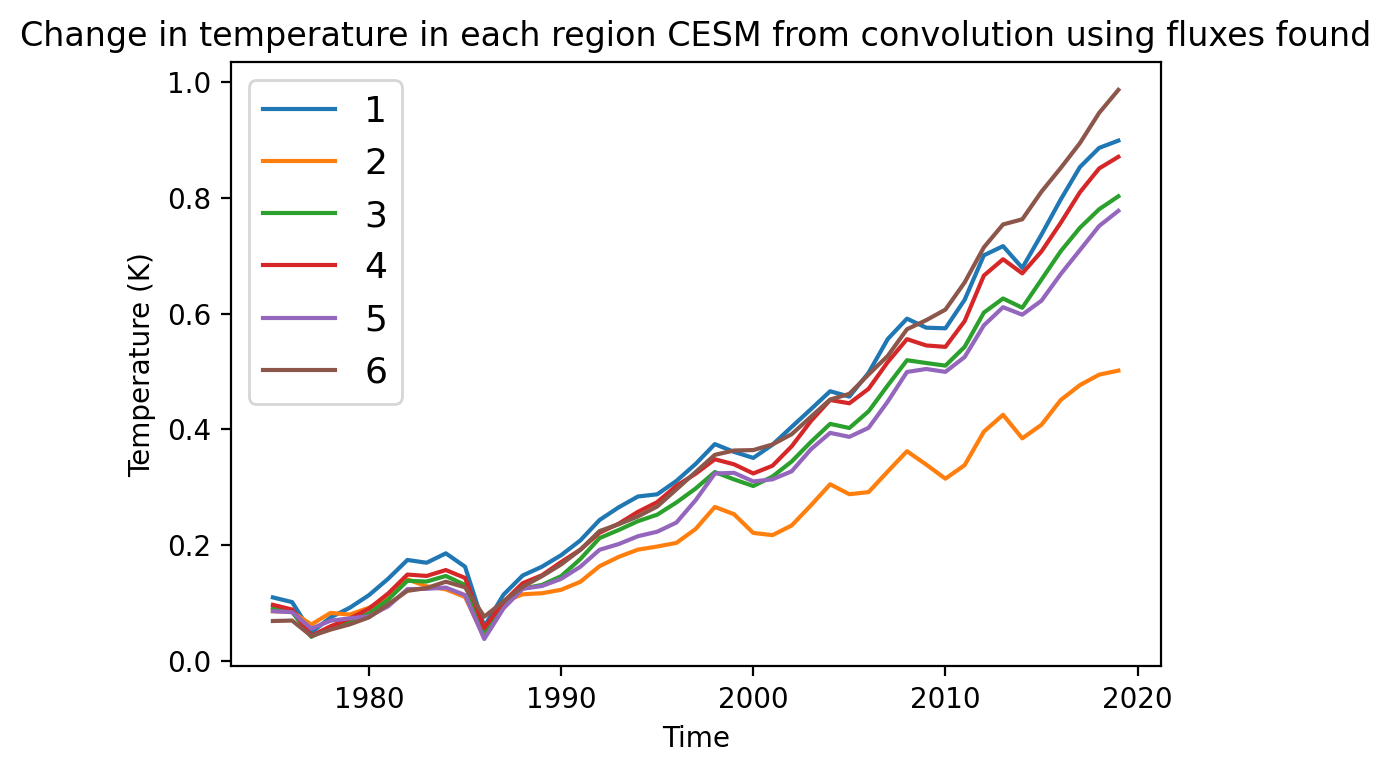

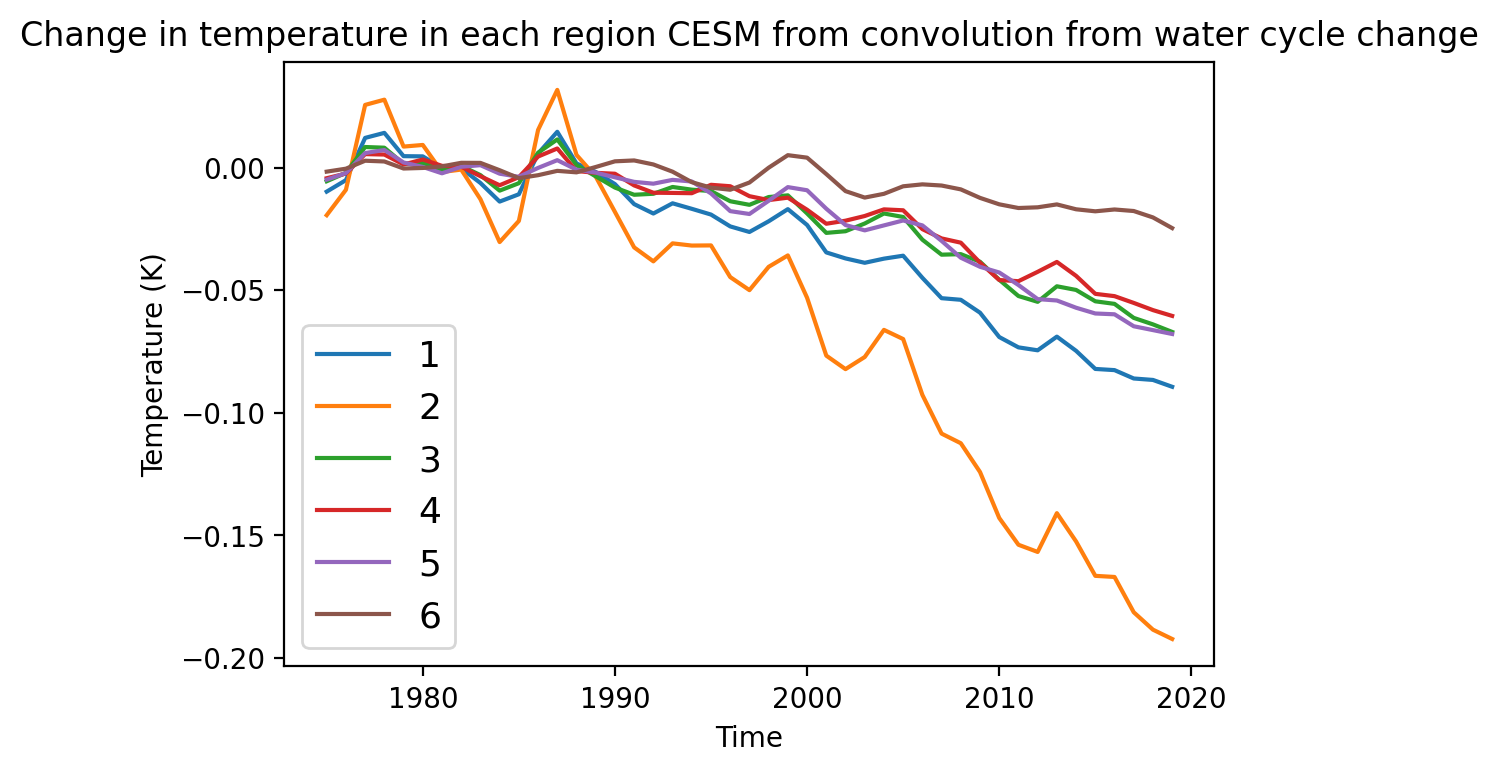

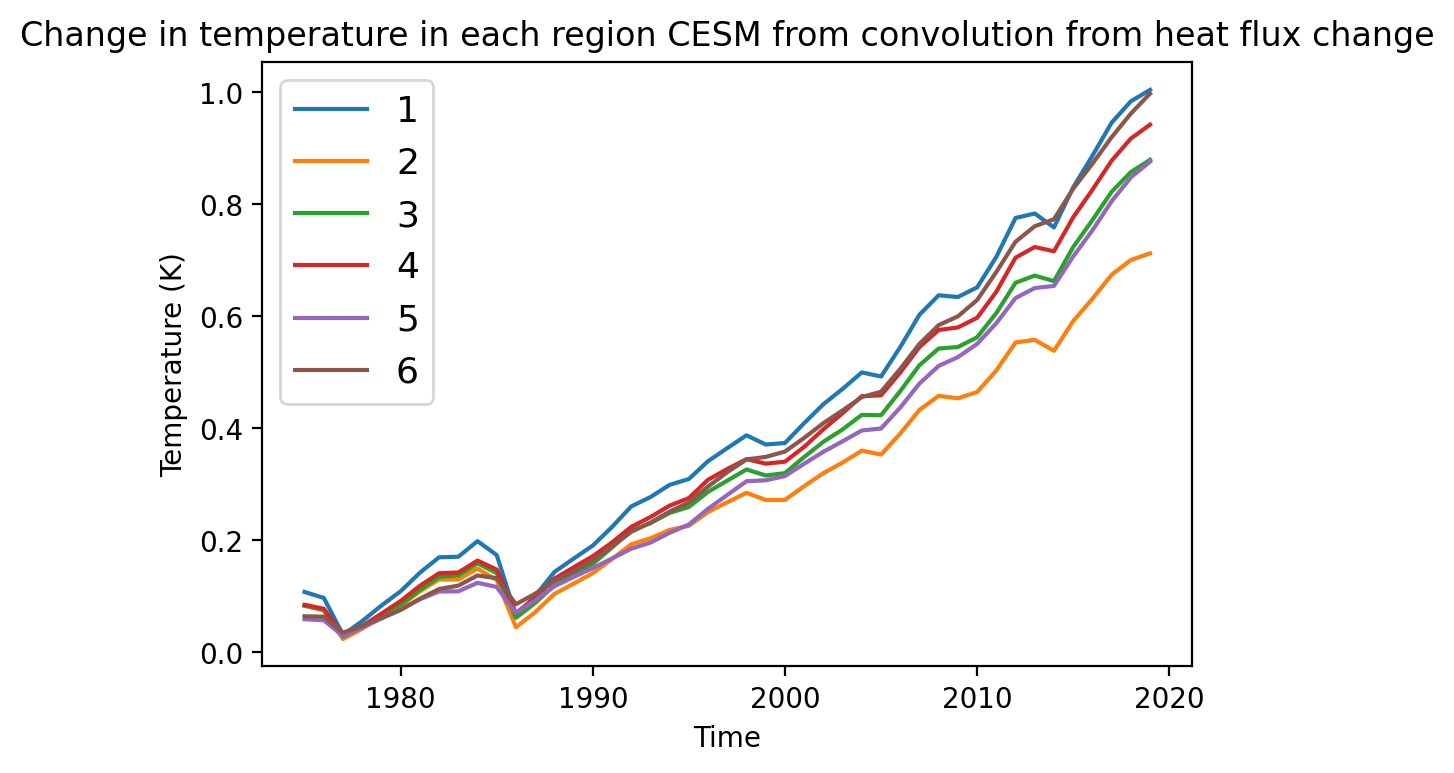

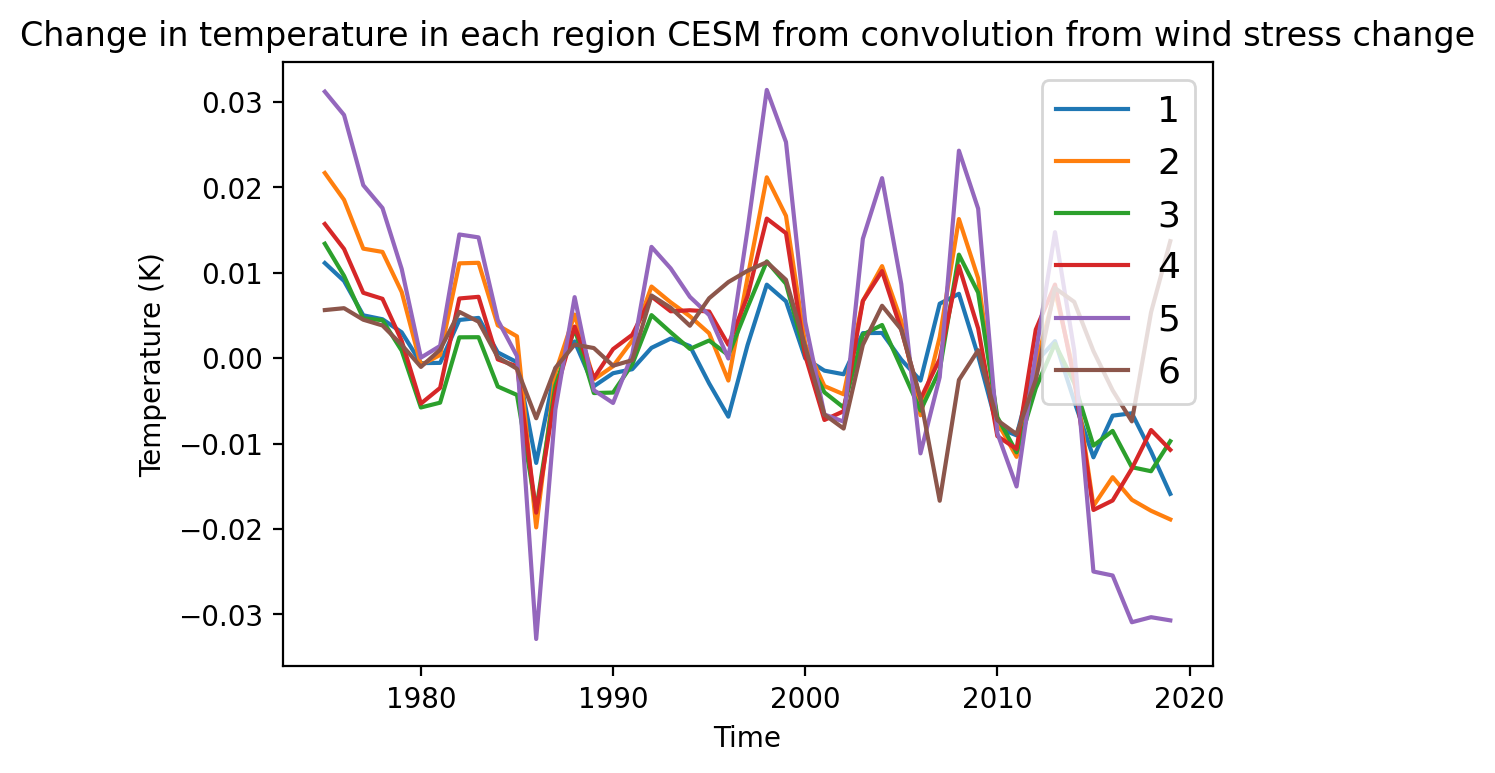

In [33]:
#We can now use the answer we found and convolve with the FAFMIP response to see if we recover close to the CESM2 response
change_temp_water_mit=temp_mit_water[:,:]-temp_mit_water[0,:]
change_temp_heat_mit=temp_mit_heat[:,:]-temp_mit_heat[0,:]
change_temp_stress_mit=temp_mit_stress[:,:]-temp_mit_stress[0,:]

change_temp_water_access=temp_access_water[:,:]-temp_access_water[0,:]
change_temp_heat_access=temp_access_heat[:,:]-temp_access_heat[0,:]
change_temp_stress_access=temp_access_stress[:,:]-temp_access_stress[0,:]

change_temp_water_had=temp_had_water[:,:]-temp_had_water[0,:]
change_temp_heat_had=temp_had_heat[:,:]-temp_had_heat[0,:]
change_temp_stress_had=temp_had_stress[:,:]-temp_had_stress[0,:]

#change_temp_water=np.mean([change_temp_water_had[19:70],change_temp_water_mit[19:70]],axis=0)
#change_temp_heat=np.mean([change_temp_heat_had[19:70],change_temp_heat_mit[19:70]],axis=0)
#change_temp_stress=np.mean([change_temp_stress_had[19:70],change_temp_stress_mit[19:70]],axis=0)


change_temp_water=np.mean([change_temp_water_access[16:67],change_temp_water_mit[16:67]],axis=0)
change_temp_heat=np.mean([change_temp_heat_access[16:67],change_temp_heat_mit[16:67]],axis=0)
change_temp_stress=np.mean([change_temp_stress_access[16:67],change_temp_stress_mit[16:67]],axis=0)

change_temp_fafmip=np.stack((change_temp_water,change_temp_heat,change_temp_stress))

df_new=np.mean(np.mean(df,axis=1),axis=2)
#np.mean(df,axis=1)[:,:,1]


conv=np.zeros([3,50,n])
conv2=np.zeros([3,50,n])
for p in range(0,3):
    for k in range(0,n):
        for i in range(0,50):
            sum=0
            for j in range(0,i+1):
                sum=(change_temp_fafmip[p,i-j,k])*df_new[j,p]+sum #mit0,access1,had2 #FIX THIS, THIS ISNT QUITE RIGHT. WANT TO MULTIPLY WITH THE TIME DERIV VERSION AND THEN SUM INSTEAD OF SUMMED DERIV
            conv[p,i,k]=sum
            conv2[:,i,k]=conv[:,i,k].cumsum(axis=0)

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),np.sum(conv,axis=0)[5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region CESM from convolution using fluxes found')

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),conv[0,5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region CESM from convolution from water cycle change')

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),conv[1,5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region CESM from convolution from heat flux change')

fig,ax=plt.subplots()
plt.plot(np.linspace(1975,2019,45),conv[2,5:50,:])
plt.legend(['1','2','3','4','5','6','7'])
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region CESM from convolution from wind stress change')

0.5854203327124974
3.8250976519759354
0.1530471600927851


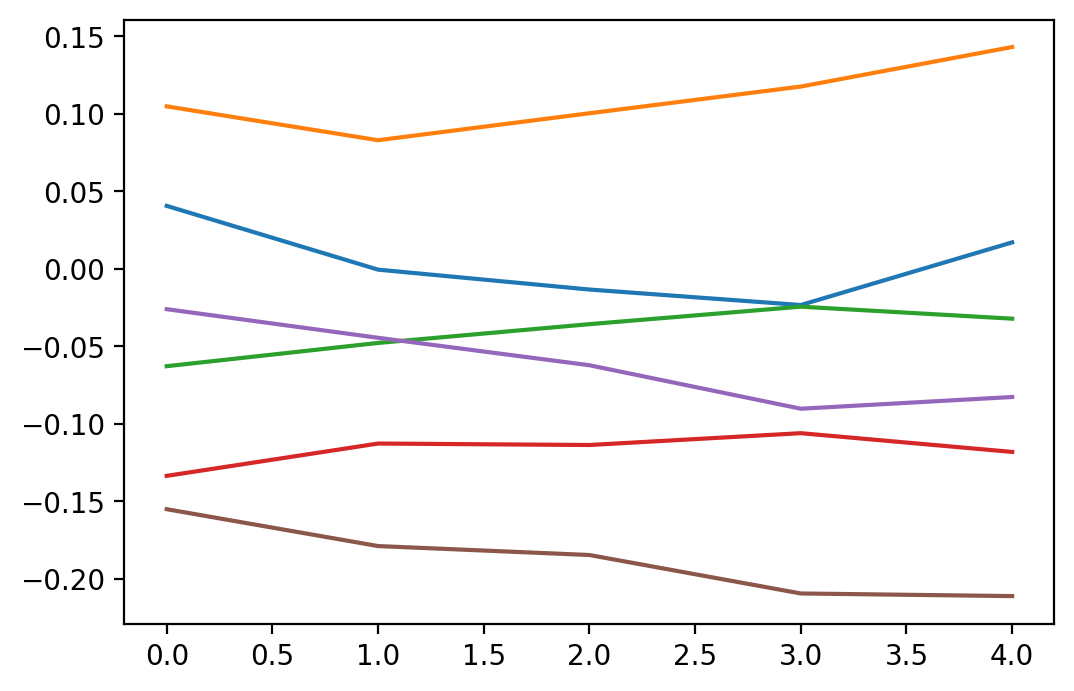

In [38]:
plt.plot(change_temp_cesm[45:50,:]-np.sum(conv,axis=0)[45:50,:])
print(np.linalg.norm(change_temp_cesm[45:50,:]-np.sum(conv,axis=0)[45:50,:]))
print(np.linalg.norm(change_temp_cesm[45:50,:]))
print(np.linalg.norm(change_temp_cesm[45:50,:]-np.sum(conv,axis=0)[45:50,:])/np.linalg.norm(change_temp_cesm[45:50,:]))

##TEMP

0.07957289330905838
0.282788244175456
0.2813868502245354


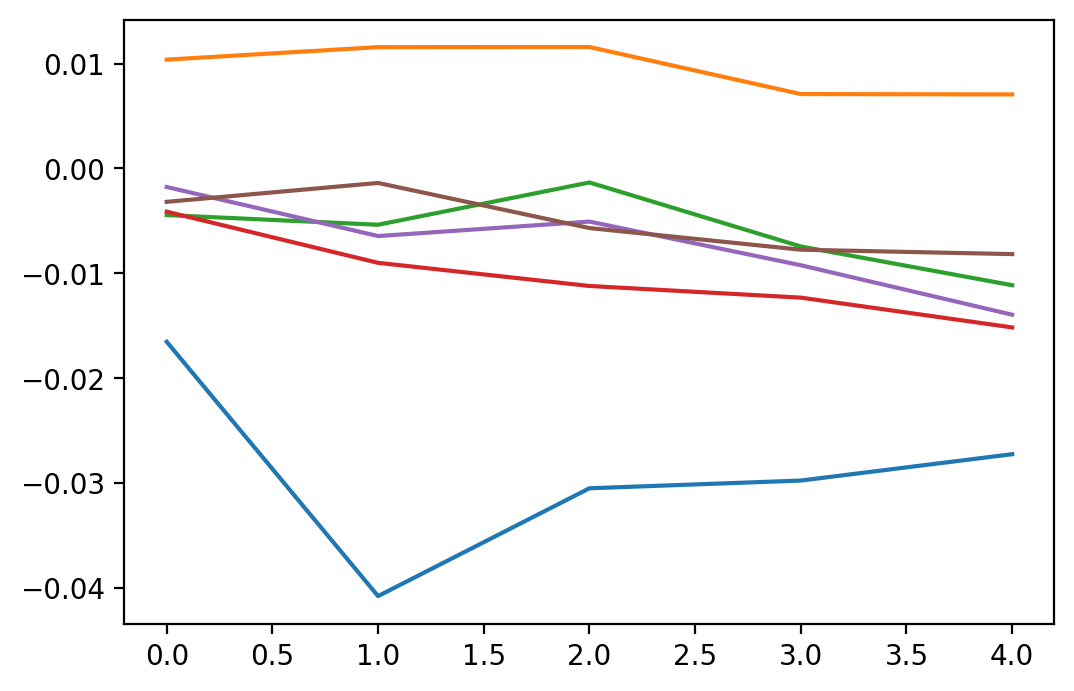

In [72]:
plt.plot(change_cesm[45:50,:]-np.sum(conv,axis=0)[45:50,:])
print(np.linalg.norm(change_cesm[45:50,:]-np.sum(conv,axis=0)[45:50,:]))
print(np.linalg.norm(change_cesm[45:50,:]))
print(np.linalg.norm(change_cesm[45:50,:]-np.sum(conv,axis=0)[45:50,:])/np.linalg.norm(change_cesm[45:50,:]))
##SALT DIFFERENCE

In [141]:
from linear_response_functions import regridded_fafmip_coupled
%load_ext autoreload
%autoreload 2
salt_gfdl_stress,salt_mpi_stress,salt_hadgem_stress,salt_gfdl_heat,salt_mpi_heat,salt_hadgem_heat,salt_gfdl_water,salt_mpi_water,salt_hadgem_water=regridded_fafmip_coupled(salt_avg_1970to2020,area,a2,n)


from linear_response_functions import regridded_fafmip_coupled_temp
%load_ext autoreload
%autoreload 2
temp_gfdl_stress,temp_mpi_stress,temp_hadgem_stress,temp_gfdl_heat,temp_mpi_heat,temp_hadgem_heat,temp_gfdl_water,temp_mpi_water,temp_hadgem_water=regridded_fafmip_coupled_temp(salt_avg_1970to2020,area,a2,n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is no

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is no

In [245]:
f='/scratch/abf376/FAFMIP/MPI-ESM/FAF-water/so_yr_MPI-ESM-LR-remap_FAF-water_r1i1p1.nc'
file2read = netCDF4.Dataset(f,'r') #use this line if you want to see the descriptions
    #print(file2read.variables)
test=xr.open_dataset(f)['sea_water_salinity']
test=test.where(test !=9.969209968386869e+36) #get rid of weird values

In [246]:
test

<xarray.DataArray 'sea_water_salinity' (time: 150, depth: 40, latitude: 180,
                                        longitude: 360)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [31.825642, 31.83001 , 31.834581, ..., 31.813782, 31.817528,
          31.821482],
         [31.82601 , 31.828009, 31.829983, ..., 31.8185  , 31.821316,
          31.823984],
         [31.799059, 31.799898, 31.800732, ..., 31.796513, 31.797367,
          31.798216]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]],

        [[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * longitude           (longitude) float64 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * latitude            (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * depth               (depth) float32 6.0 17.0 27.0 ... 5.17e+03 5.72e+03
    model_level_number  (depth) int32 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40
  * time                (time) datetime64[ns] 1850-07-02T12:00:00 ... 1999-07...
Attributes:
    standard_name:  sea_water_salinity
    units:          psu
    long_name:      salinity (ocean) (psu-35)/1000
    cell_methods:   area: mean time: mean

In [189]:
#Smooth
change_water=salt_had_water[:,:]
change_heat=salt_had_heat[:,:]
change_stress=salt_had_stress[:,:]
change_water_temp=temp_had_water[:,:]
change_heat_temp=temp_had_heat[:,:]
change_stress_temp=temp_had_stress[:,:]
da = xr.DataArray(change_water)
salt_had_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat)
salt_had_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress)
salt_had_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_water_temp)
temp_had_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat_temp)
temp_had_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress_temp)
temp_had_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')


change_water=salt_hadgem_water[:,:]
change_heat=salt_hadgem_heat[:,:]
change_stress=salt_hadgem_stress[:,:]
change_water_temp=temp_hadgem_water[:,:]
change_heat_temp=temp_hadgem_heat[:,:]
change_stress_temp=temp_hadgem_stress[:,:]
da = xr.DataArray(change_water)
salt_hadgem_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat)
salt_hadgem_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress)
salt_hadgem_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_water_temp)
temp_hadgem_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat_temp)
temp_hadgem_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress_temp)
temp_hadgem_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')


change_water=salt_gfdl_water[:,:]
change_heat=salt_gfdl_heat[:,:]
change_stress=salt_gfdl_stress[:,:]
change_water_temp=temp_gfdl_water[:,:]
change_heat_temp=temp_gfdl_heat[:,:]
change_stress_temp=temp_gfdl_stress[:,:]
da = xr.DataArray(change_water)
salt_gfdl_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat)
salt_gfdl_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress)
salt_gfdl_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_water_temp)
temp_gfdl_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat_temp)
temp_gfdl_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress_temp)
temp_gfdl_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')


change_water=salt_mpi_water[:,:]
change_heat=salt_mpi_heat[:,:]
change_stress=salt_mpi_stress[:,:]
change_water_temp=temp_mpi_water[:,:]
change_heat_temp=temp_mpi_heat[:,:]
change_stress_temp=temp_mpi_stress[:,:]
da = xr.DataArray(change_water)
salt_mpi_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat)
salt_mpi_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress)
salt_mpi_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_water_temp)
temp_mpi_water_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_heat_temp)
temp_mpi_heat_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
da = xr.DataArray(change_stress_temp)
temp_mpi_stress_smooth=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')

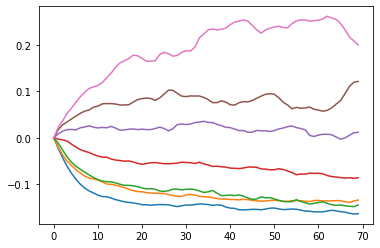

In [190]:
plt.plot(salt_access_water-salt_access_water[0,:])

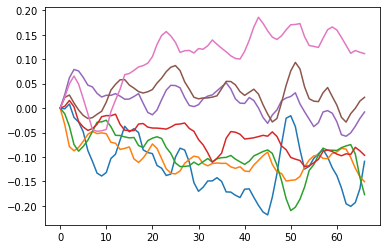

In [191]:
plt.plot(salt_had_water_smooth-salt_had_water_smooth[0,:])

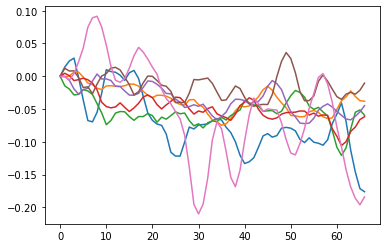

In [192]:
plt.plot(salt_hadgem_water_smooth-salt_hadgem_water_smooth[0,:])

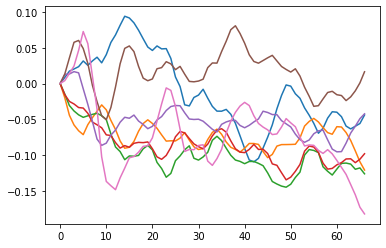

In [193]:
plt.plot(salt_mpi_water_smooth-salt_mpi_water_smooth[0,:])
plt.set_xlabel('Time')
plt.set_ylabel('Response to freshwater forcing')

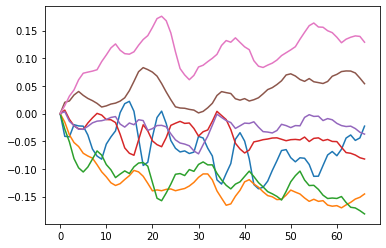

In [194]:
plt.plot(salt_gfdl_water_smooth-salt_gfdl_water_smooth[0,:])

In [241]:
start_yr=14
end_yr=19

#df=np.zeros([50,end_yr-start_yr,3,2])
#df2=np.zeros([50,end_yr-start_yr,3,2])
#df4=np.zeros([50,end_yr-start_yr,3,2])
#dist=np.zeros([50,end_yr-start_yr,3])
df=np.zeros([50,end_yr-start_yr,3,6])
df2=np.zeros([50,end_yr-start_yr,3,6])
df4=np.zeros([50,end_yr-start_yr,3,6])
dist=np.zeros([50,end_yr-start_yr,6])
for p in range(0,6):

    access1mit0had2=p

    start_yr=14
    end_yr=19
    for start in range(start_yr,end_yr):

        if access1mit0had2==0:
            change_water=salt_mit_water[:,:]-salt_mit_water[0,:]
            change_heat=salt_mit_heat[:,:]-salt_mit_heat[0,:]
            change_stress=salt_mit_stress[:,:]-salt_mit_stress[0,:]
            change_water_temp=temp_mit_water[:,:]-temp_mit_water[0,:]
            change_heat_temp=temp_mit_heat[:,:]-temp_mit_heat[0,:]
            change_stress_temp=temp_mit_stress[:,:]-temp_mit_stress[0,:]
        elif access1mit0had2==1:
            change_water=salt_access_water[:,:]-salt_access_water[0,:]
            change_heat=salt_access_heat[:,:]-salt_access_heat[0,:]
            change_stress=salt_access_stress[:,:]-salt_access_stress[0,:]
            change_water_temp=temp_access_water[:,:]-temp_access_water[0,:]
            change_heat_temp=temp_access_heat[:,:]-temp_access_heat[0,:]
            change_stress_temp=temp_access_stress[:,:]-temp_access_stress[0,:]
        elif access1mit0had2==2:
            change_water=salt_had_water[:,:]-salt_had_water[0,:]
            change_heat=salt_had_heat[:,:]-salt_had_heat[0,:]
            change_stress=salt_had_stress[:,:]-salt_had_stress[0,:]
            change_water_temp=temp_had_water[:,:]-temp_had_water[0,:]
            change_heat_temp=temp_had_heat[:,:]-temp_had_heat[0,:]
            change_stress_temp=temp_had_stress[:,:]-temp_had_stress[0,:]
        elif p==3:
            change_water=salt_hadgem_water[:,:]-salt_hadgem_water[0,:]
            change_heat=salt_hadgem_heat[:,:]-salt_hadgem_heat[0,:]
            change_stress=salt_hadgem_stress[:,:]-salt_hadgem_stress[0,:]
            change_water_temp=temp_hadgem_water[:,:]-temp_hadgem_water[0,:]
            change_heat_temp=temp_hadgem_heat[:,:]-temp_hadgem_heat[0,:]
            change_stress_temp=temp_hadgem_stress[:,:]-temp_hadgem_stress[0,:]
        elif p==4:
            change_water=salt_gfdl_water[:,:]-salt_gfdl_water[0,:]
            change_heat=salt_gfdl_heat[:,:]-salt_gfdl_heat[0,:]
            change_stress=salt_gfdl_stress[:,:]-salt_gfdl_stress[0,:]
            change_water_temp=temp_gfdl_water[:,:]-temp_gfdl_water[0,:]
            change_heat_temp=temp_gfdl_heat[:,:]-temp_gfdl_heat[0,:]
            change_stress_temp=temp_gfdl_stress[:,:]-temp_gfdl_stress[0,:]
        elif p==5:
            change_water=salt_mpi_water[:,:]-salt_mpi_water[0,:]
            change_heat=salt_mpi_heat[:,:]-salt_mpi_heat[0,:]
            change_stress=salt_mpi_stress[:,:]-salt_mpi_stress[0,:]
            change_water_temp=temp_mpi_water[:,:]-temp_mpi_water[0,:]
            change_heat_temp=temp_mpi_heat[:,:]-temp_mpi_heat[0,:]
            change_stress_temp=temp_mpi_stress[:,:]-temp_mpi_stress[0,:]
            
        if p>=2:
           da = xr.DataArray(change_water)
           change_water=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_heat)
           change_heat=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_stress)
           change_stress=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_water_temp)
           change_water_temp=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_heat_temp)
           change_heat_temp=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_stress_temp)
           change_stress_temp=da.rolling(dim_0=6,center=True).mean().dropna('dim_0')

        #a=np.max(change_temp_cesm2)/np.max(change_cesm2)
        a=np.linalg.norm(change_temp_cesm)/np.linalg.norm(change_cesm)

        change2_water=np.concatenate((change_water[start:71],change_water_temp[start:71]/a),axis=1)
        change2_heat=np.concatenate((change_heat[start:71],change_heat_temp[start:71]/a),axis=1)
        if p==1:
            change2_stress=np.concatenate((change_stress[start:67],change_stress_temp[start:71]/a),axis=1)
        elif p>=2:
            change2_stress=np.concatenate((change_stress[start:71],change_stress_temp[start:71]/a),axis=1)
        elif p==0:
            change2_stress=np.concatenate((change_stress[start:71],change_stress_temp[start:71]/a),axis=1)

        change_cesm2_stack=np.concatenate((change_cesm,change_temp_cesm/a),axis=1)
        
        for i in range(0,46):
            sum=np.zeros(2*n)
            for j in range(0,i):
                B=np.concatenate((np.matrix(change2_water[i-j,:]).T,np.matrix(change2_heat[i-j,:]).T,np.matrix(change2_stress[i-j,:]).T),axis=1)
                sum=((B)*np.matrix(df[j,start-start_yr,:,p]).T).T+sum
            RHS=change_cesm2_stack[i+1,:].T-sum
            A=np.concatenate((np.matrix(change2_water[0,:]).T,np.matrix(change2_heat[0,:]).T,np.matrix(change2_stress[0,:]).T),axis=1)
            #A=np.concatenate((np.matrix(change2_water[0,:]).T,np.matrix(change2_heat[0,:]).T),axis=1)
            #df[i,start-start_yr,:,p]=(np.linalg.inv(np.matmul(A.T,A))*np.matmul(A.T,np.matrix(RHS).T)).reshape(3)
            #dist[i,start-start_yr,p] = np.linalg.norm(np.matmul(A,df[i,start-start_yr,:,p])-RHS)
            x, residuals, rank, s=np.linalg.lstsq(A,np.matrix(RHS).T,rcond = -1)
            df[i,start-start_yr,:,p]=x.reshape(3)


        for k in range(0,3):
            df2[:,start-start_yr,k,p]=(df[:,start-start_yr,k,p].cumsum())-(df[:,start-start_yr,k,p].cumsum())[0] #subtract off so starts from 0
            df4[:,start-start_yr,k,p]=(df[:,start-start_yr,k,p].cumsum()) #don't subtract off so starts at 0
        df3=np.mean(df2,axis=1) #mean over the start years where we subtracted off
        df5=np.mean(df4,axis=1) #mean over the start years where we didn't make start from 0
df3_mean=np.mean(df3,axis=2)
df5_mean=np.mean(df5,axis=2)

2.4098712626355368e-20
0.0052550650190950525
0.0049166153226641975
0.005593514715525908
0.2627532509547526
0.24583076613320987
0.2796757357762954


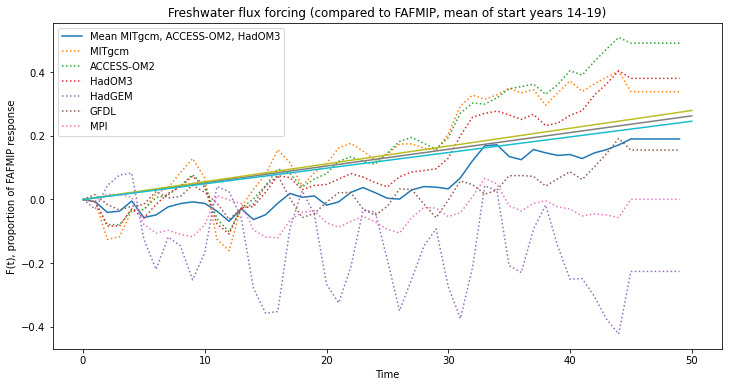

In [242]:
fig,ax=plt.subplots(figsize=(12,6))
plt.plot(df3_mean[:,0])
plt.plot(df3[:,0,0],':')
plt.plot(df3[:,0,1],':')
plt.plot(df3[:,0,2],':')
plt.plot(df3[:,0,3],':')
plt.plot(df3[:,0,4],':')
plt.plot(df3[:,0,5],':')
plt.title('Freshwater flux forcing (compared to FAFMIP, mean of start years 14-19)')
plt.xlabel('Time')
plt.ylabel('F(t), proportion of FAFMIP response')
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3','HadGEM','GFDL','MPI'])
p=scipy.stats.linregress(np.linspace(0,50,50), y=df3_mean[:,0], alternative='two-sided')
print(p.pvalue)
print(p.slope)
print(p.slope-p.stderr)
print(p.slope+p.stderr)
plt.plot(np.linspace(0,50,50),p.slope*np.linspace(0,50,50))
plt.plot(np.linspace(0,50,50),(p.slope+p.stderr)*np.linspace(0,50,50))
plt.plot(np.linspace(0,50,50),(p.slope-p.stderr)*np.linspace(0,50,50))
print(p.slope*50)
print((p.slope-p.stderr)*50)
print((p.slope+p.stderr)*50)